In [1]:
import sys
import warnings

sys.path.append("./packages/")
warnings.filterwarnings("ignore")

import calmap
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly_express as px
from scipy.fft import fft

from FeatureEngineering import FeatureEngineer
from Processing import DataProcessor
from Vizualizer import GeneralPresentator, PatternAnalyzer, DataPlotter

## 0. Import et mise en forme de la data

> Importation

In [2]:
DATA_PATH = './../data/'
TARGET = 'Global_active_power_Wh'

df = pd.read_csv(f'{DATA_PATH}household_power_consumption.txt',
                 sep=';',                            # separateur = ;
                 header=0,                           # ligne des header = 1ère ligne
                 low_memory=False,                   # parsing complet
                 infer_datetime_format=True,         # parsing des dates
                 )


> 0.2 Mise en forme des dtypes de date et création des variables de temps

dire c'est quoi les étapes qui ont été faites

In [3]:
cols = ['Global_active_power', 'Global_reactive_power', 'Voltage',
        'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

dp = DataProcessor(df)
df = dp.process_data(cols)
df.head()


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,month,year,Global_active_power_Wh,other_submetering
datetime,,,,,,,,,,,,,,
2006-12-16 17:24:00,2006-12-16,17:24:00,4.214844,0.417969,234.875,18.406250,0.0,1.0,17.0,16,12,2006,70.247398,52.247398
2006-12-16 17:25:00,2006-12-16,17:25:00,5.359375,0.436035,233.625,23.000000,0.0,1.0,16.0,16,12,2006,89.322914,72.322914
2006-12-16 17:26:00,2006-12-16,17:26:00,5.375000,0.498047,233.250,23.000000,0.0,2.0,17.0,16,12,2006,89.583336,70.583336
2006-12-16 17:27:00,2006-12-16,17:27:00,5.386719,0.501953,233.750,23.000000,0.0,1.0,17.0,16,12,2006,89.778648,71.778648
2006-12-16 17:28:00,2006-12-16,17:28:00,3.666016,0.527832,235.625,15.796875,0.0,1.0,17.0,16,12,2006,61.100262,43.100262


## 1. Explication du problème de machine learning que vous souhaitez résoudre

Georges Hebrail et Alice Berard, employés d'EDF travaillant dans le pôle R&D, ont mis à disposition des [données de consommation éléctrique](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption#) des ménages de Sceaux, une ville située à 7km de Paris. Ces données couvrent la période du 16 décembre 2006 au 26 novembre 2010. Bien que ces données n'aient pas été associées à une problématique particulière et qu'aucun papier de recherche n'ait été publié sur ce sujet, nous les considérons comme une excellente base de départ pour notre projet de Deep Learning sur des séries temporelles.  

Nous imaginons trois possibles problématiques pour ce sujet:
- Prédire la puissance consommée active ;
- Prédire la puissance consommée réactive ;
- Prédire la puissance consommée apparente: $\sqrt(Global\_active\_power^2 + Global\_reactive\_power^2)$.

Dans tous les cas, l'objectif est d'optimiser la production d'électricité d'EDF en évitant la surproduction, ce qui permet de réduire les coûts et l'impact environnemental. En prévoyant les pics de consommation, il est également possible d'informer les ménages afin qu'ils puissent adapter leur consommation et réduire leur impact. Finalement, nous allons prédire la puissance consommée active, qui représente l'énergie effectivement transformée et utilisée par les ménages. La puissance réactive, quant à elle, est une puissance électromagnétique latente dans le réseau électrique, produite par des appareils tels que des bobines ou des moteurs. Cette énergie n'est pas facturée par EDF et suppose un coût, cependant elle est essentielle pour faire fonctionner ces types d'appareils. Il faut noter que la puissance réactive est assez stable dans le réseau électrique, ce qui suppose un bruit si on s'intéresse à prédire la somme des deux, la puissance consommée apparente.

Il est important de noter qu'il faut définir un horizon de prédiction. Pour cela, nous nous sommes intéressés au [parc électrique](https://www.statistiques.developpement-durable.gouv.fr/edition-numerique/chiffres-cles-energie-2021/6-bilan-energetique-de-la-france#:~:text=Le%20bouquet%20%C3%A9nerg%C3%A9tique%20primaire%20r%C3%A9el,d%C3%A9chets%20et%202%20%25%20de%20charbon.) français. Nous avons appris que la production électrique peut s'adapter en quelques minutes si le changement n'est pas de plus de 50% de la production entre $t$ et $t+1$. Si c'était le cas, il faudrait arrêter la production nucléaire et cela pourrait prendre quelques heures dans le meilleur des cas. Cependant, des alternatives existent, comme le stockage d'électricité dans des batteries, bien que cela soit coûteux. En conséquence de la rapide adaptation de la production, nous trouvons pertinent de prédire dans la minute. Nous serons donc très proches de ce qu'en finance est appelé "nowcasting" qui est de prédire dans la minute ou même dans la seconde qui vient.


## 2. Présentation du jeu de données

### Description du jeu de données de consommation électrique

Le jeu de données de consommation électrique est fourni par le pôle R&D d'EDF et contient les données de consommation électrique des ménages de Sceaux entre le 16 décembre 2006 et le 26 novembre 2010, à la minute près, pour un total de 2 049 280 observations. 

Il est important de noter que les données sont en format texte séparées par des points-virgules (;) et que les valeurs manquantes sont représentées par des champs vides. Nous devrons donc travailler sur le formatage du DataFrame pour avoir une bonne lecture de la base de données.

### Variables

La base de données brute est composée de 9 variables :  
- `Date` : La date (au format dd/mm/yyyy)
- `Time` : L'heure (au format hh:mm:ss)
- `Global_active_power` : La puissance active moyenne par minute dans l'ensemble du foyer (en kilowatts)
- `Global_reactive_power` : La puissance réactive moyenne par minute dans l'ensemble du foyer (en kilowatts)
- `Voltage` : La tension moyenne par minute (en volts)
- `Global_intensity` : L'intensité de courant moyenne par minute dans l'ensemble du foyer (en ampères)
- `Sub_metering_1` : Le sous-compteur d'énergie n°1 (en watt-heures d'énergie active). Il correspond à la cuisine, contenant principalement un lave-vaisselle, un four et un micro-ondes (les plaques de cuisson ne sont pas électriques mais alimentées au gaz).
- `Sub_metering_2` : Le sous-compteur d'énergie n°2 (en watt-heures d'énergie active). Il correspond à la buanderie, contenant une machine à laver, un sèche-linge, un réfrigérateur et un éclairage.
- `Sub_metering_3` : Le sous-compteur d'énergie n°3 (en watt-heures d'énergie active). Il correspond à un chauffe-eau électrique et un climatiseur.
- `other_metering`: Il correspond à tout autre consommation éléctrique (en watt-heures d'énergie active) = $(global\_active\_power*1000/60 - sub\_metering\_1 - sub\_metering\_2 - sub\_metering\_3)$

Dans ce print de l'information basique nous pouvons voir le type de données que nous allons traiter. En générale, elles sont toutes numériques sauf le temps et l'heure. Nous parlerons de la distribution plus tard. Aussi nous nous apercevons de la présence de NaN. 

In [4]:
gs = GeneralPresentator(df)

gs.print_basic_prez()


Column Names:
['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'day', 'month', 'year', 'Global_active_power_Wh', 'other_submetering']

Data Types:


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,month,year,Global_active_power_Wh,other_submetering
0,datetime64[ns],category,float16,float16,float16,float16,float16,float16,float16,int8,int8,int16,float32,float32



Basic Statistics:


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,month,year,Global_active_power_Wh,other_submetering
count,2.049280e+06,2.049280e+06,2049280.000,2.049280e+06,2049280.0,2049280.0,2049280.0,2.075259e+06,2.075259e+06,2.075259e+06,2.049280e+06,2.049280e+06
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.577363e+01,6.450359e+00,2.008437e+03,1.819355e+01,9.314665e+00
std,0.000000e+00,0.000000e+00,0.000,0.000000e+00,0.0,0.0,0.0,8.787773e+00,3.415762e+00,1.128677e+00,1.762157e+01,9.585917e+00
min,7.598877e-02,0.000000e+00,223.250,1.999512e-01,0.0,0.0,0.0,1.000000e+00,1.000000e+00,2.006000e+03,1.266479e+00,-2.404947e+00
25%,3.081055e-01,4.800415e-02,239.000,1.400391e+00,0.0,0.0,0.0,8.000000e+00,3.000000e+00,2.007000e+03,5.135091e+00,3.802734e+00
50%,6.020508e-01,9.997559e-02,241.000,2.599609e+00,0.0,0.0,1.0,1.600000e+01,6.000000e+00,2.008000e+03,1.003418e+01,5.501302e+00
75%,1.528320e+00,1.939697e-01,242.875,6.398438e+00,0.0,1.0,17.0,2.300000e+01,9.000000e+00,2.009000e+03,2.547201e+01,1.036914e+01
max,1.112500e+01,1.389648e+00,254.125,4.840625e+01,88.0,80.0,31.0,3.100000e+01,1.200000e+01,2.010000e+03,1.854167e+02,1.248385e+02



Missing Values:


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,month,year,Global_active_power_Wh,other_submetering
0,0,0,25979,25979,25979,25979,25979,25979,25979,0,0,0,25979,25979



Unique values for day:
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31  1  2  3  4  5  6  7  8
  9 10 11 12 13 14 15]

Unique values for month:
[12  1  2  3  4  5  6  7  8  9 10 11]

Unique values for year:
[2006 2007 2008 2009 2010]

Sample Data:


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,month,year,Global_active_power_Wh,other_submetering
datetime,,,,,,,,,,,,,,
2006-12-16 17:24:00,2006-12-16,17:24:00,4.214844,0.417969,234.875,18.406250,0.0,1.0,17.0,16,12,2006,70.247398,52.247398
2006-12-16 17:25:00,2006-12-16,17:25:00,5.359375,0.436035,233.625,23.000000,0.0,1.0,16.0,16,12,2006,89.322914,72.322914
2006-12-16 17:26:00,2006-12-16,17:26:00,5.375000,0.498047,233.250,23.000000,0.0,2.0,17.0,16,12,2006,89.583336,70.583336
2006-12-16 17:27:00,2006-12-16,17:27:00,5.386719,0.501953,233.750,23.000000,0.0,1.0,17.0,16,12,2006,89.778648,71.778648
2006-12-16 17:28:00,2006-12-16,17:28:00,3.666016,0.527832,235.625,15.796875,0.0,1.0,17.0,16,12,2006,61.100262,43.100262


## 3. Exploration du jeu de données (Analyse descriptive, statistiques descriptives, visualisation)

### to do: sortir la proportion entre metering par mois

In [5]:
dataplots = DataPlotter(df)


> Pandas Profiling


In [6]:
# dataplots.data_profiling(granularity="3M")


> Calendar overview

In [7]:
# create the treemap
# fig = px.treemap(df, path=["year", "month", "day"], values="Global_active_power")

# show the plot
# fig.show()


> Calendar plots

Lorsque l'on étudie la consommation électrique totale, il est évident que celle-ci est très saisonnière. En effet, durant l'hiver, la demande en énergie augmente considérablement en raison du chauffage, car il s'agit d'une ville plutôt froide. À l'inverse, pendant l'été et les vacances, la demande diminue. Malgré cela, la consommation électrique reste globalement stable d'une année sur l'autre, bien que l'on remarque une légère hausse de la demande les week-ends. Il est important de souligner que le chauffage représente la majeure partie de la consommation électrique.

(<Figure size 2400x1500 with 5 Axes>,
 array([<AxesSubplot: ylabel='2006'>, <AxesSubplot: ylabel='2007'>,
        <AxesSubplot: ylabel='2008'>, <AxesSubplot: ylabel='2009'>,
        <AxesSubplot: ylabel='2010'>], dtype=object))

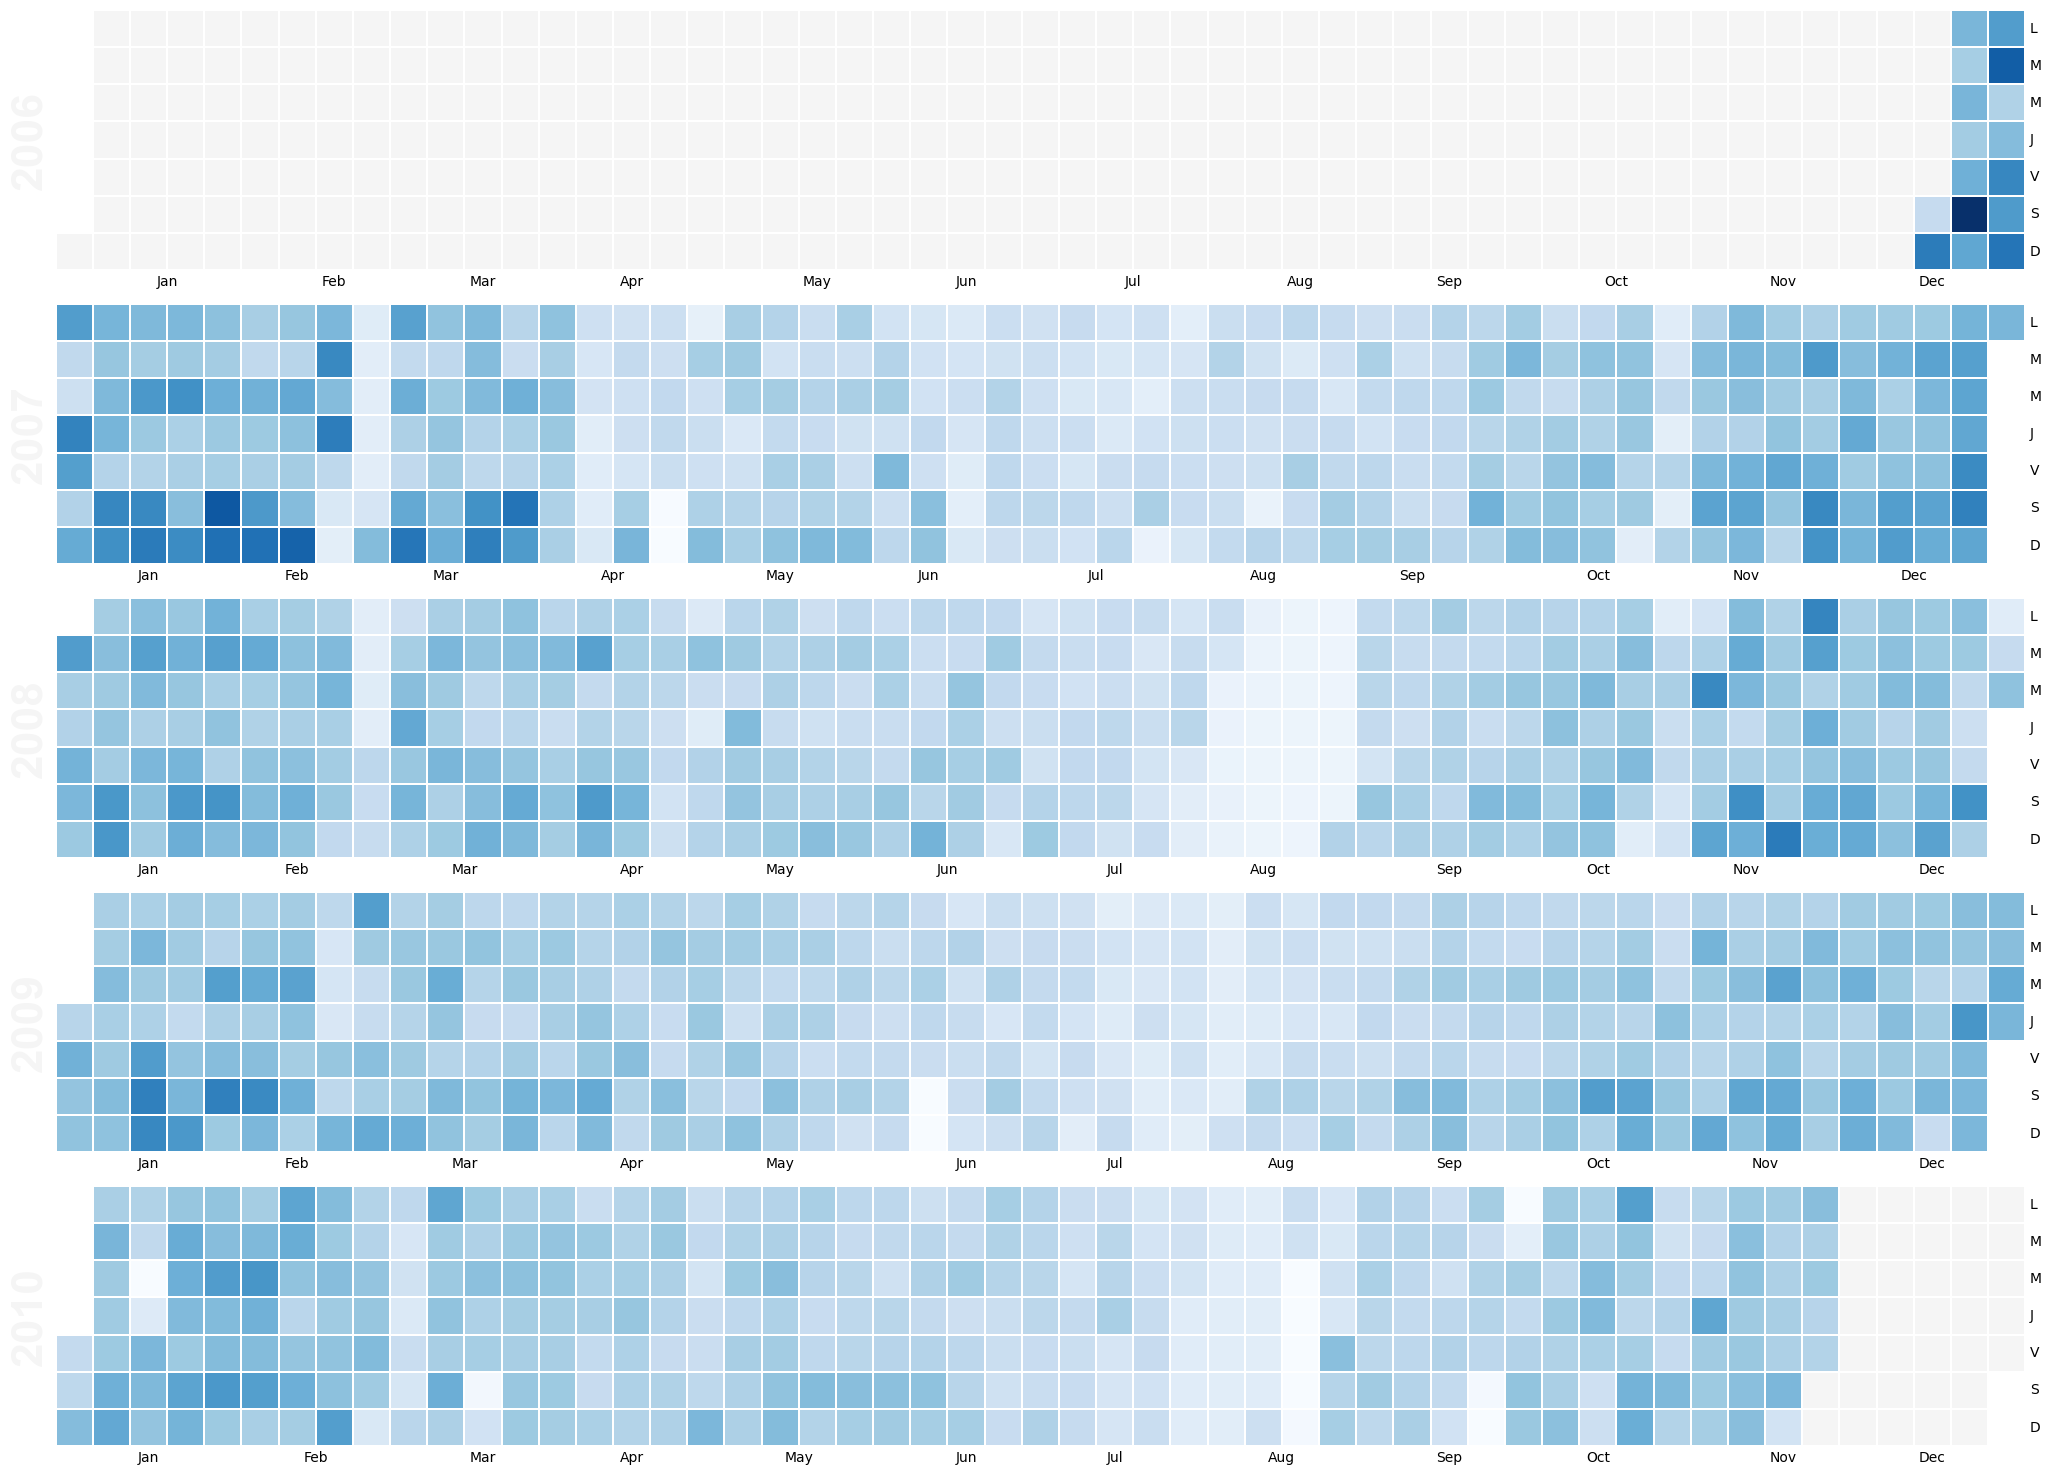

In [8]:
calmap.calendarplot(df[TARGET], monthticks=3, daylabels='LMMJVSD', cmap='Blues',
                    linewidth=0.2, fig_kws=dict(figsize=(24, 15)))


En examinant de plus près le sous-comptage de l'électricité dans la cuisine, nous pouvons observer une augmentation de la consommation électrique les week-ends, tandis que cette dernière diminue pendant les vacances et l'été. Cependant, il y a certains jours où la consommation d'énergie augmente sensiblement, et nous pouvons présumer qu'il s'agit des jours fériés.

(<Figure size 2400x1500 with 5 Axes>,
 array([<AxesSubplot: ylabel='2006'>, <AxesSubplot: ylabel='2007'>,
        <AxesSubplot: ylabel='2008'>, <AxesSubplot: ylabel='2009'>,
        <AxesSubplot: ylabel='2010'>], dtype=object))

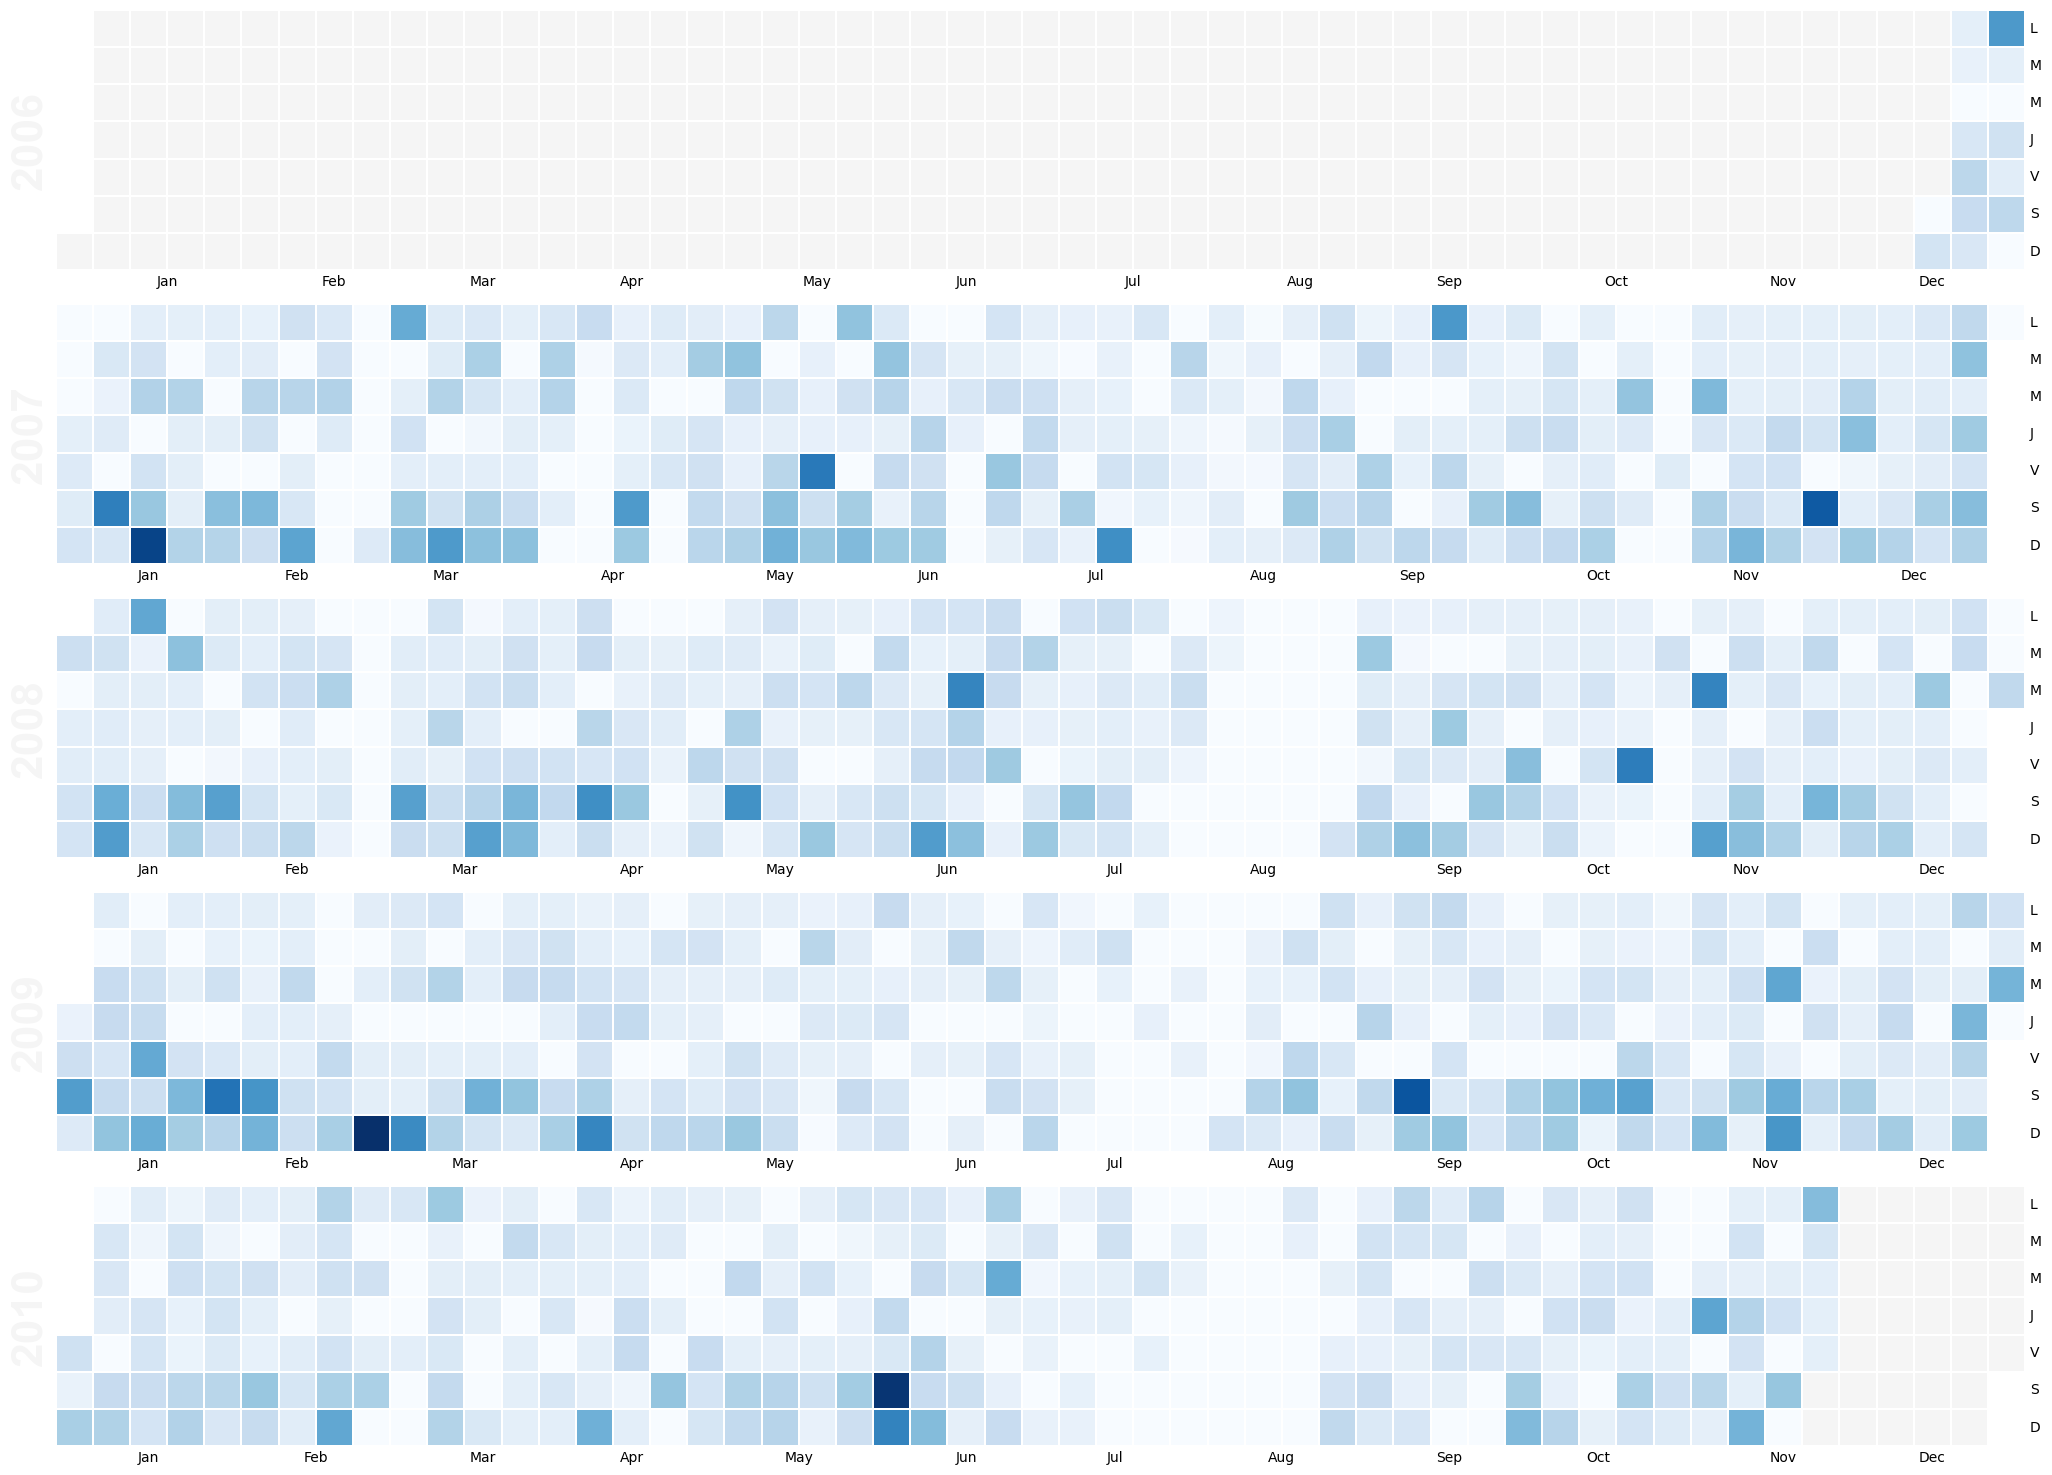

In [9]:
calmap.calendarplot(df['Sub_metering_1'], monthticks=3, daylabels='LMMJVSD', cmap='Blues',
                    linewidth=0.2, fig_kws=dict(figsize=(24, 15)))


(<Figure size 2400x1500 with 5 Axes>,
 array([<AxesSubplot: ylabel='2006'>, <AxesSubplot: ylabel='2007'>,
        <AxesSubplot: ylabel='2008'>, <AxesSubplot: ylabel='2009'>,
        <AxesSubplot: ylabel='2010'>], dtype=object))

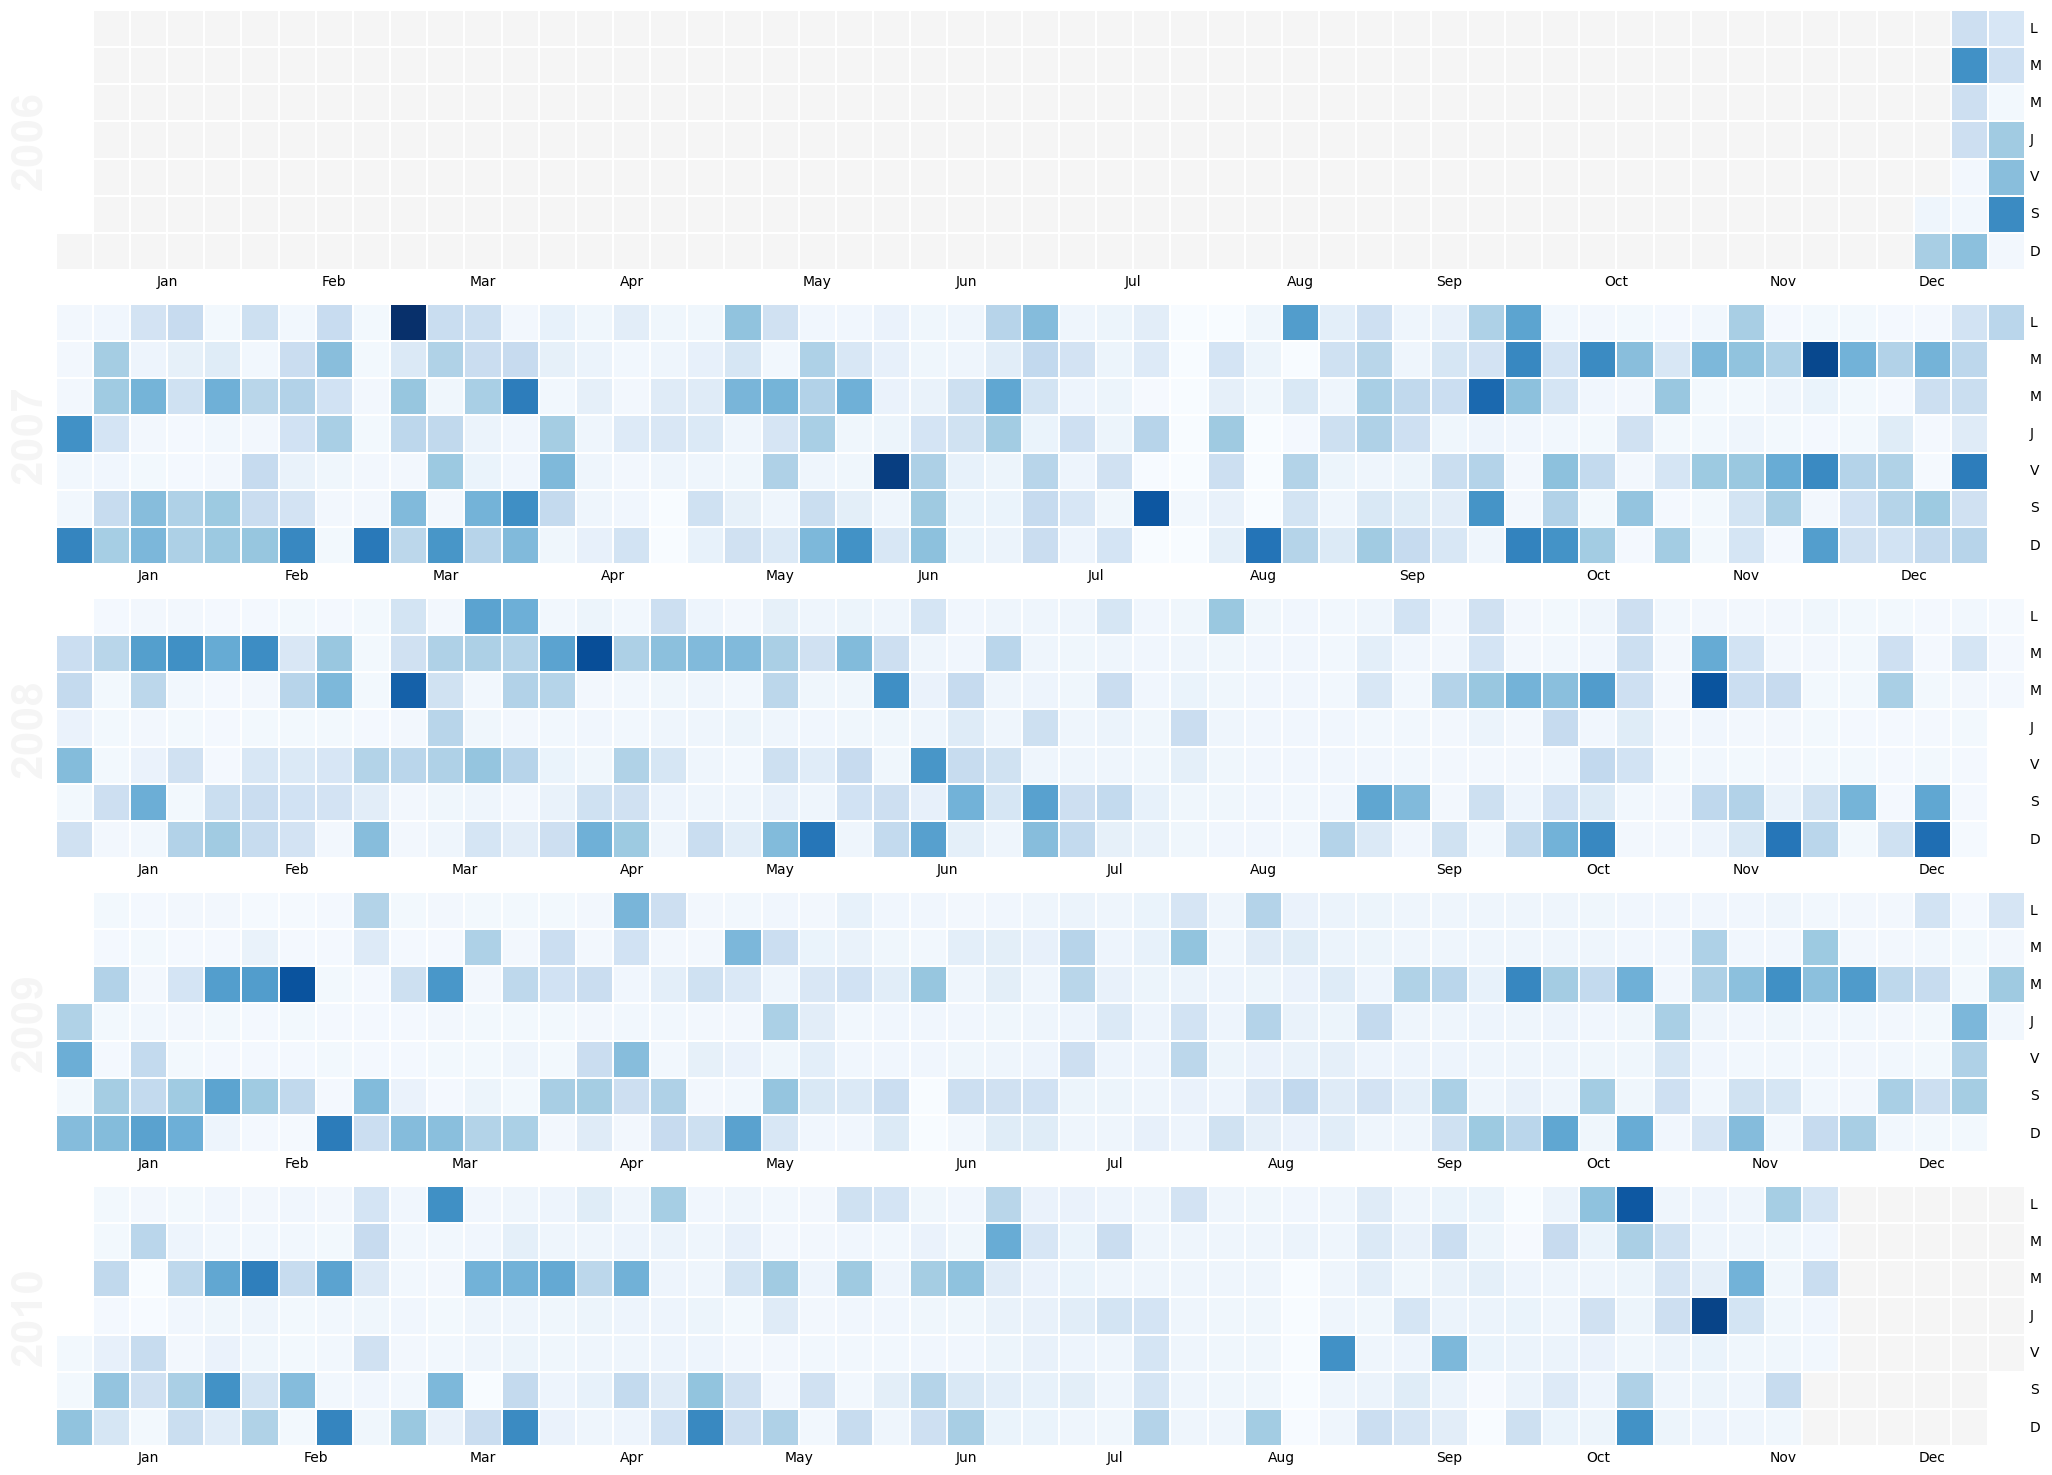

In [10]:
calmap.calendarplot(df['Sub_metering_2'], monthticks=3, daylabels='LMMJVSD', cmap='Blues',
                    linewidth=0.2, fig_kws=dict(figsize=(24, 15)))


Nous pouvons constater après avoir plot ce submetering 3 que la ville est particulièrement froide. L'été, il n'y a pas de climatisateur puisqu'il n'y a pas de consommation. En hiver et pendant les jours froids il y a une forte consommation d'éléctricité. Il s'agit d'une saisonnalité qui nous permettra d'anticiper la consommation des ménages dans les prochains jours. Par contre, l'introduction de la prévision météreologique serait très intéréssante afin de prévoir ce type de consommation. 

(<Figure size 2400x1500 with 5 Axes>,
 array([<AxesSubplot: ylabel='2006'>, <AxesSubplot: ylabel='2007'>,
        <AxesSubplot: ylabel='2008'>, <AxesSubplot: ylabel='2009'>,
        <AxesSubplot: ylabel='2010'>], dtype=object))

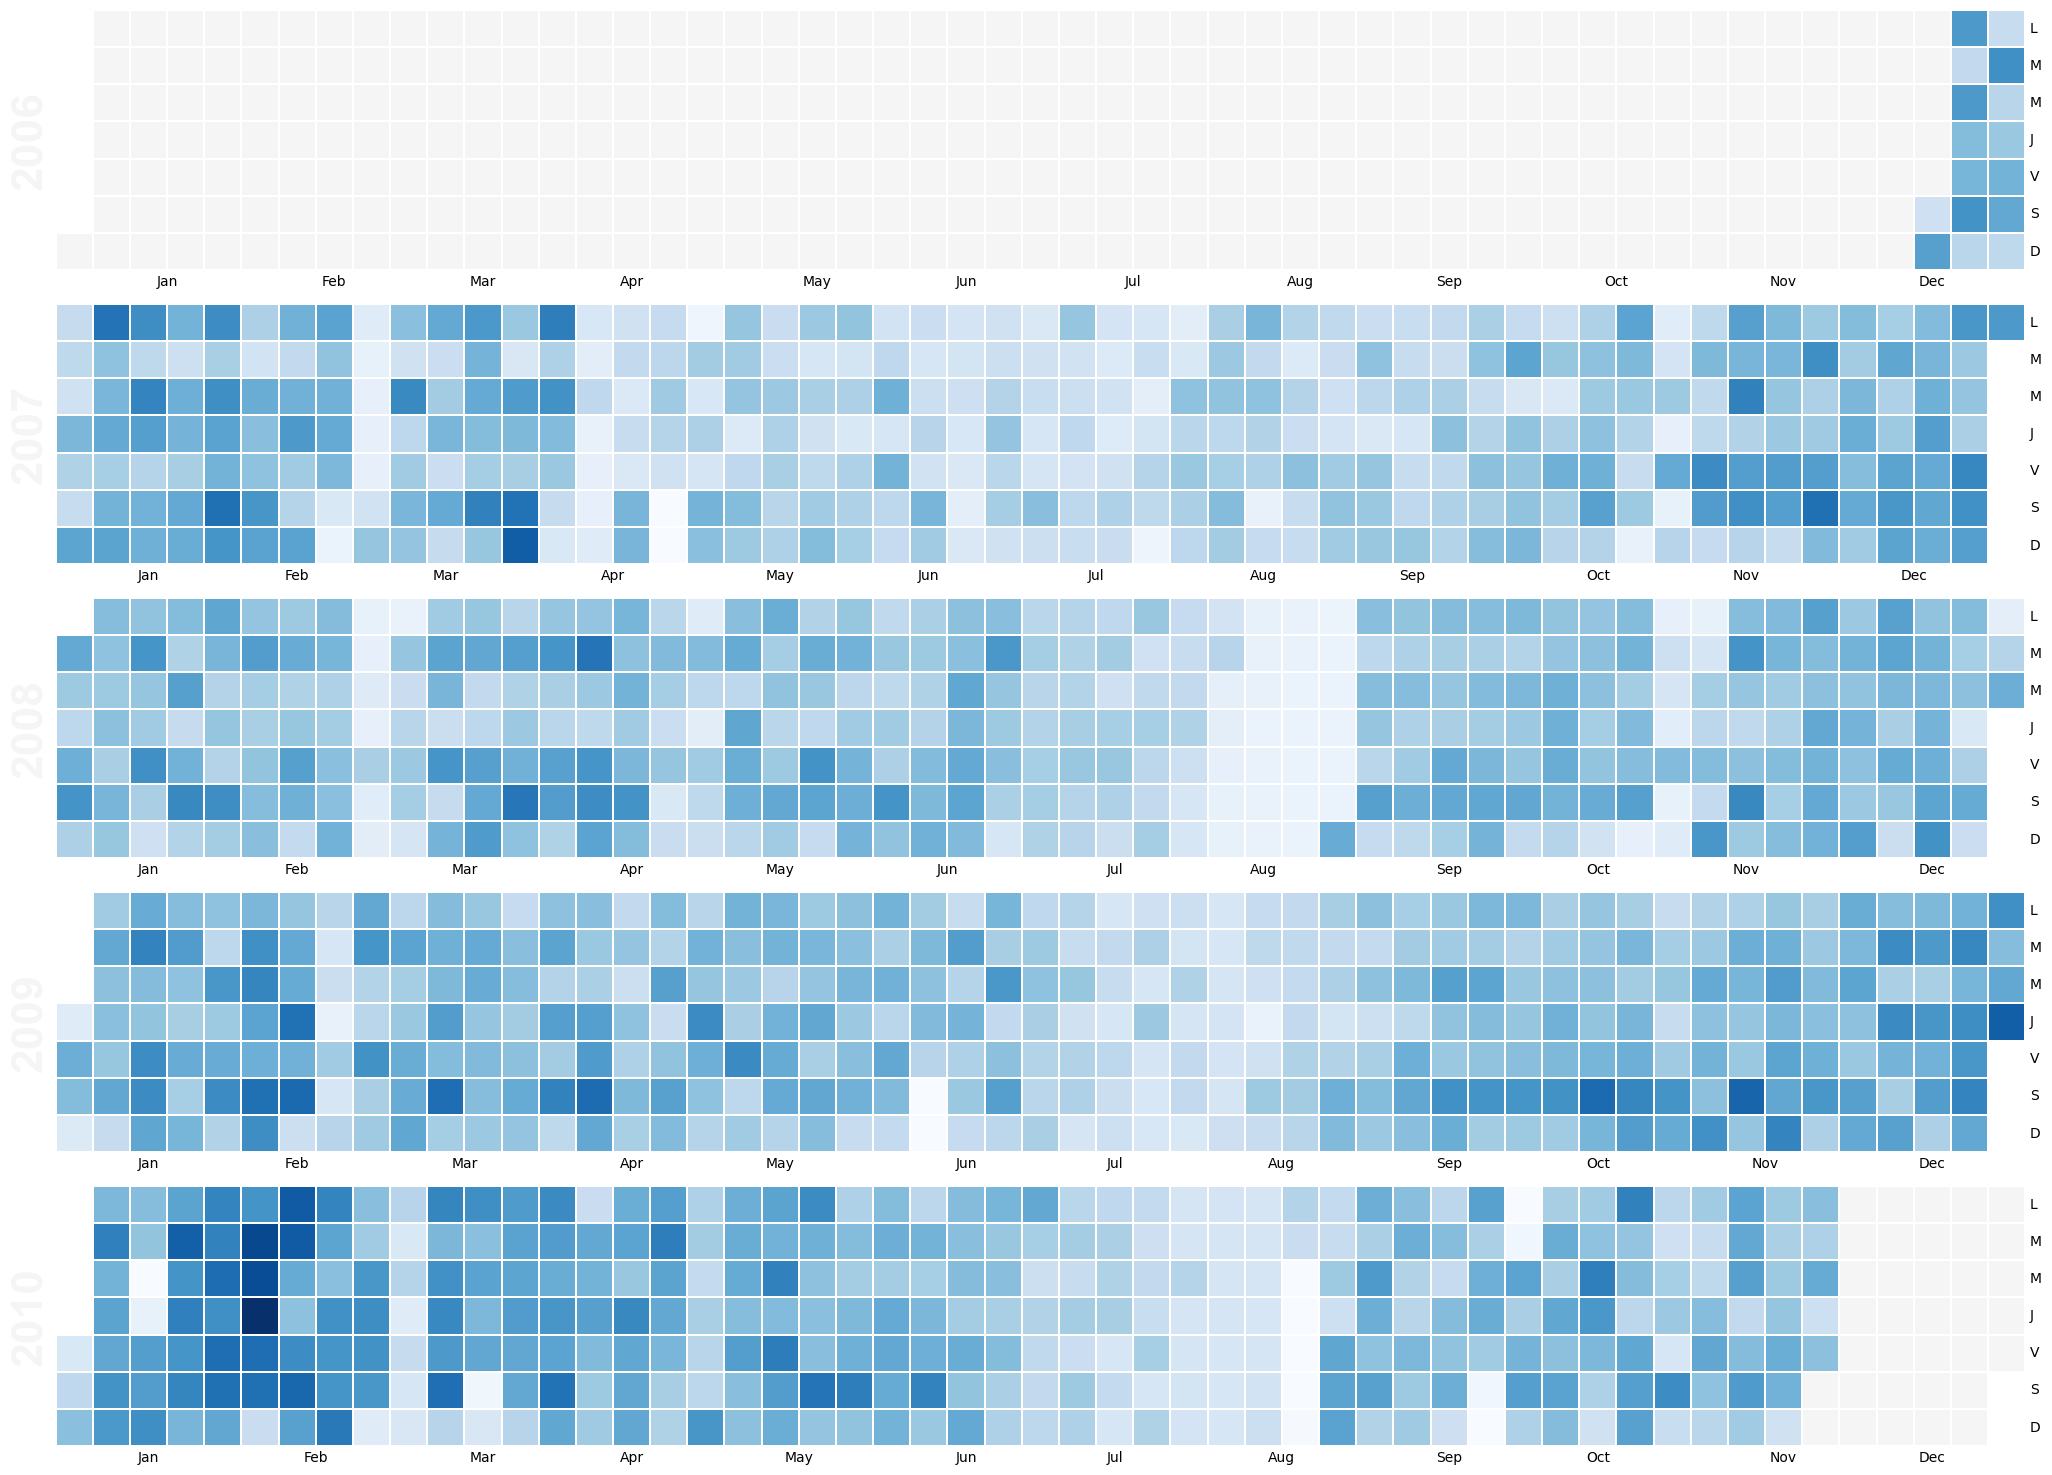

In [11]:
calmap.calendarplot(df['Sub_metering_3'], monthticks=3, daylabels='LMMJVSD', cmap='Blues',
                    linewidth=0.2, fig_kws=dict(figsize=(24, 15)))


Dans ce cas nous pouvons voir une constance, avec une faible saisonnalité en été. Cependant, pas de saisonnalité dans une granularité journalière_

(<Figure size 2400x1500 with 5 Axes>,
 array([<AxesSubplot: ylabel='2006'>, <AxesSubplot: ylabel='2007'>,
        <AxesSubplot: ylabel='2008'>, <AxesSubplot: ylabel='2009'>,
        <AxesSubplot: ylabel='2010'>], dtype=object))

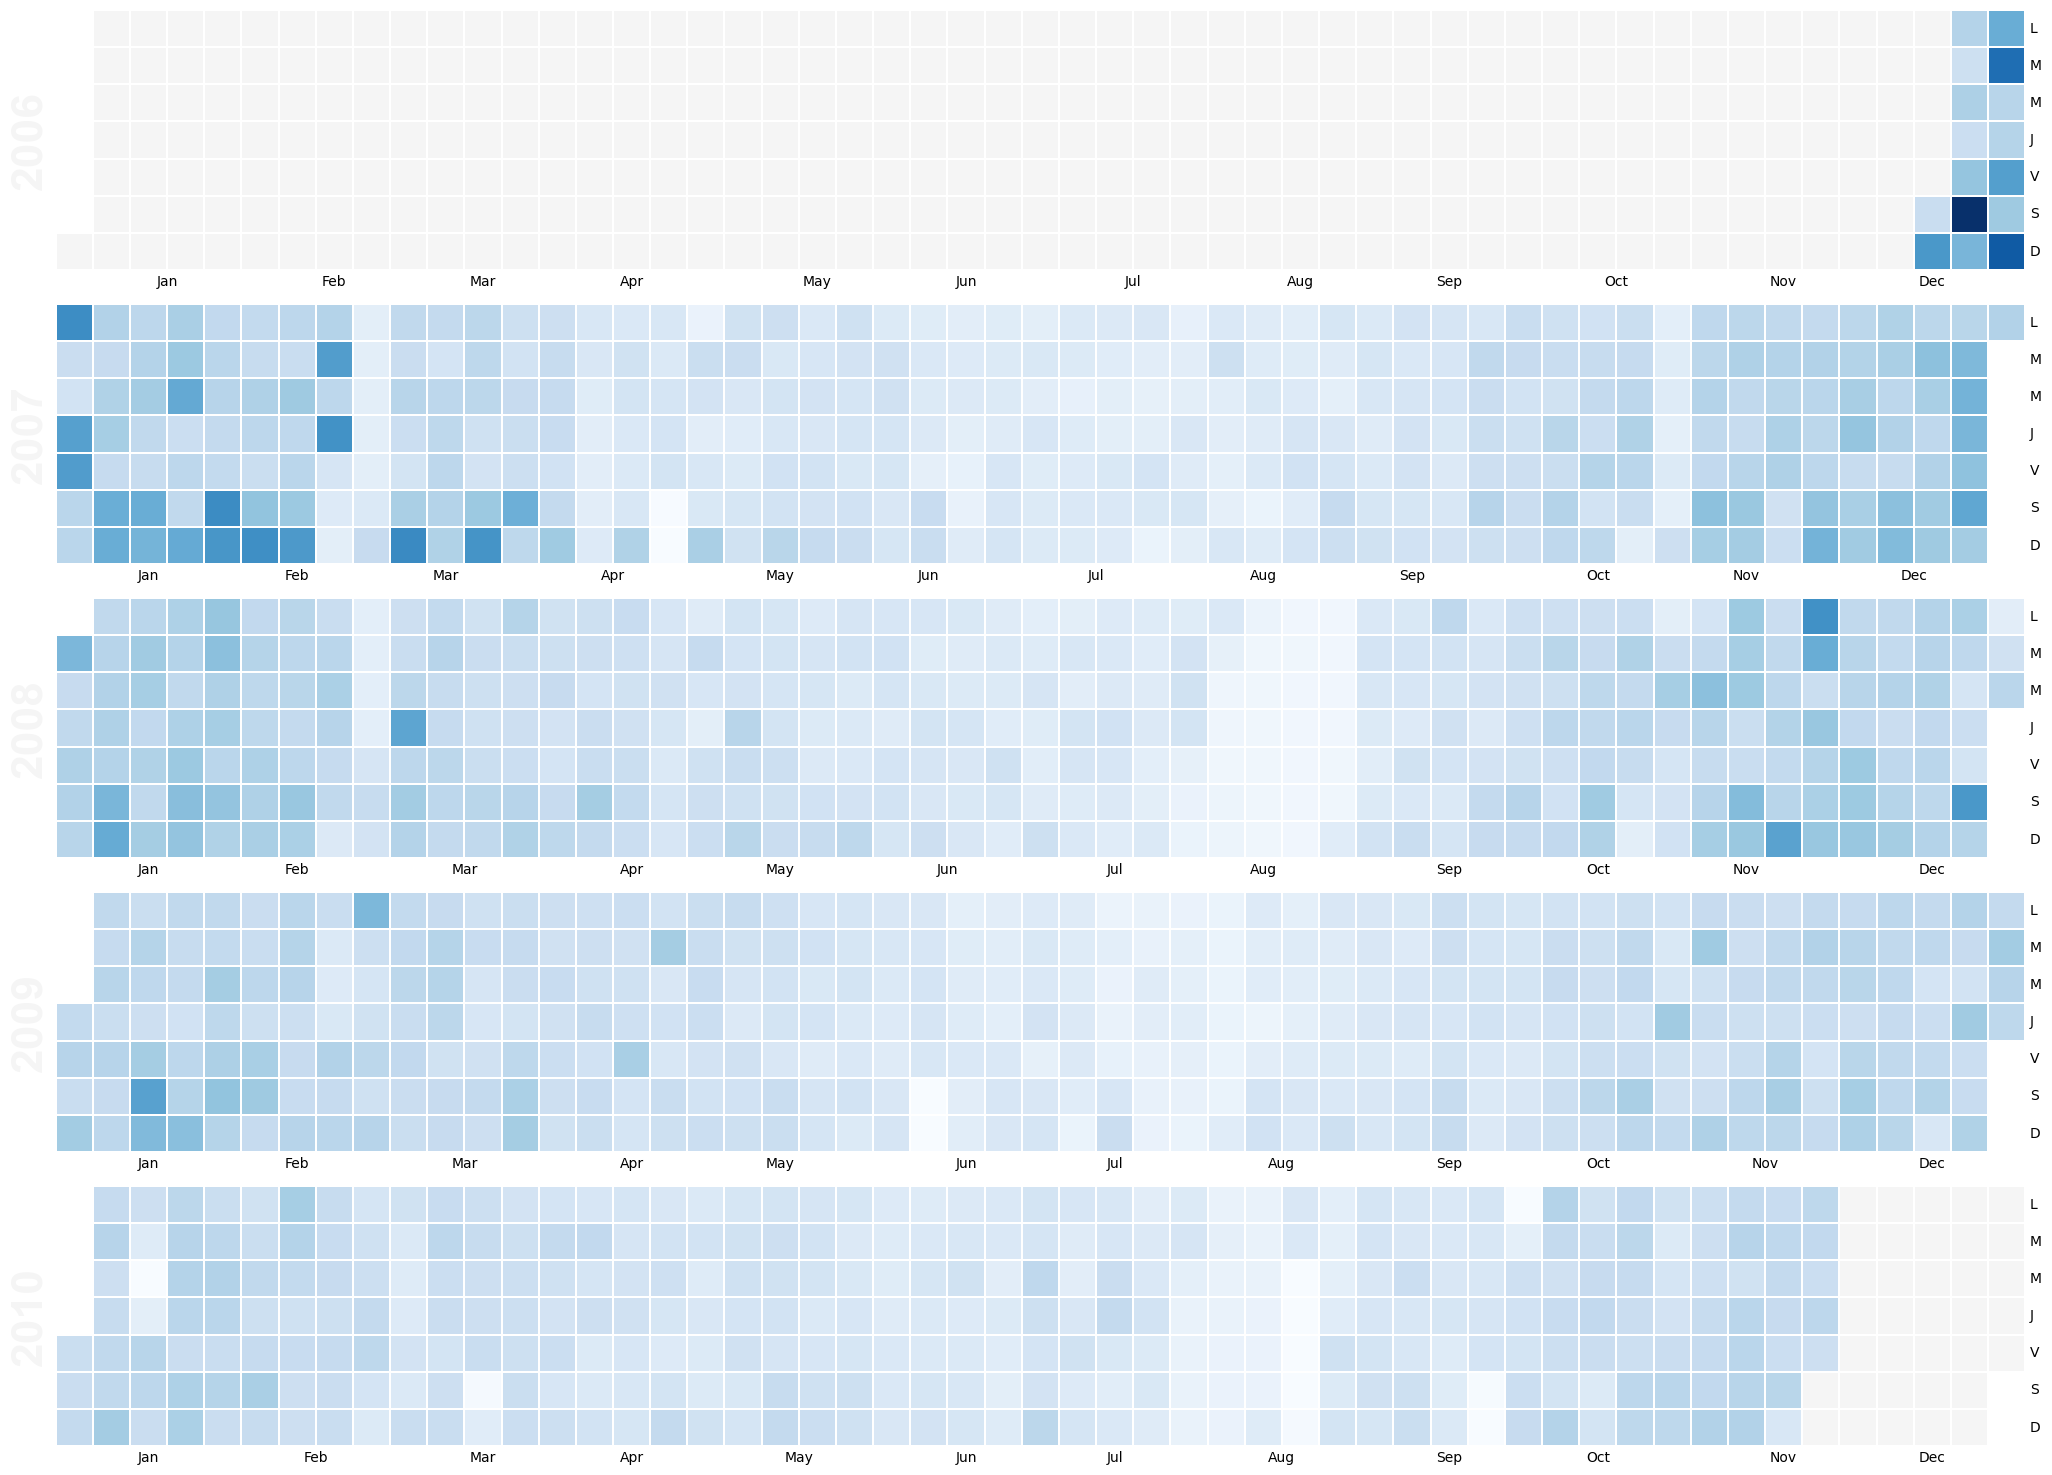

In [12]:
calmap.calendarplot(df['other_submetering'], monthticks=3, daylabels='LMMJVSD', cmap='Blues',
                    linewidth=0.2, fig_kws=dict(figsize=(24, 15)))


### Visualisation des time series

En examinant la consommation électrique sur une base trimestrielle avec la granularité la moins fine, nous pouvons constater que bien que la demande électrique globale soit très saisonnière, la consommation électrique de la cuisine et de la buanderie ne le sont pas. Toutefois, si nous examinons les données à la maille la plus fine, c'est-à-dire quotidiennement, toutes les consommations présentent une certaine saisonnalité. Cette saisonnalité pourra être prise en compte dans un futur modèle de prédiction par l'ajout de variables saisonnières telles qu'une variable binaire pour l'été ou une pour l'hiver. L'idée est que ces variables auront un poids dans le modèle qui nous permettra d'anticiper la consommation future.

In [13]:
# Suppression de la feature voltage et year pour observer les autres features
cols = list(df.columns)
viz_cols = [i for i in cols if i not in [
    'Date', 'Time', 'Voltage', 'year', 'day', 'month']]


> Plotting des times series

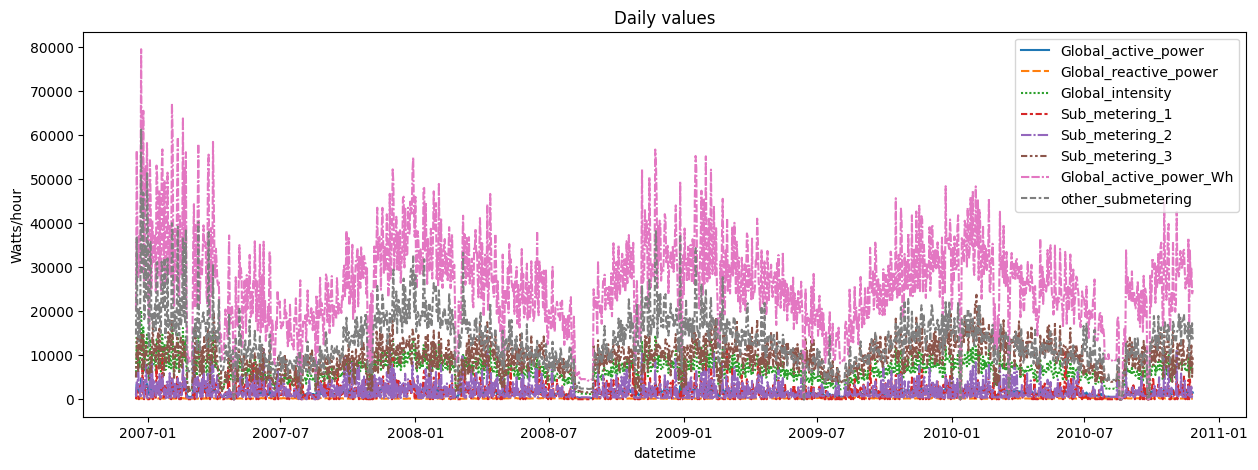

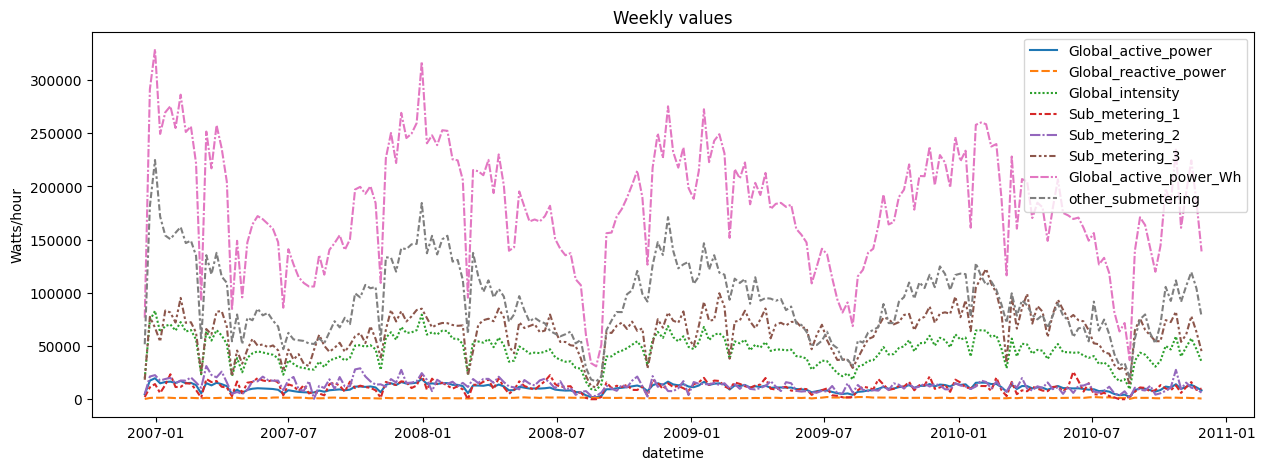

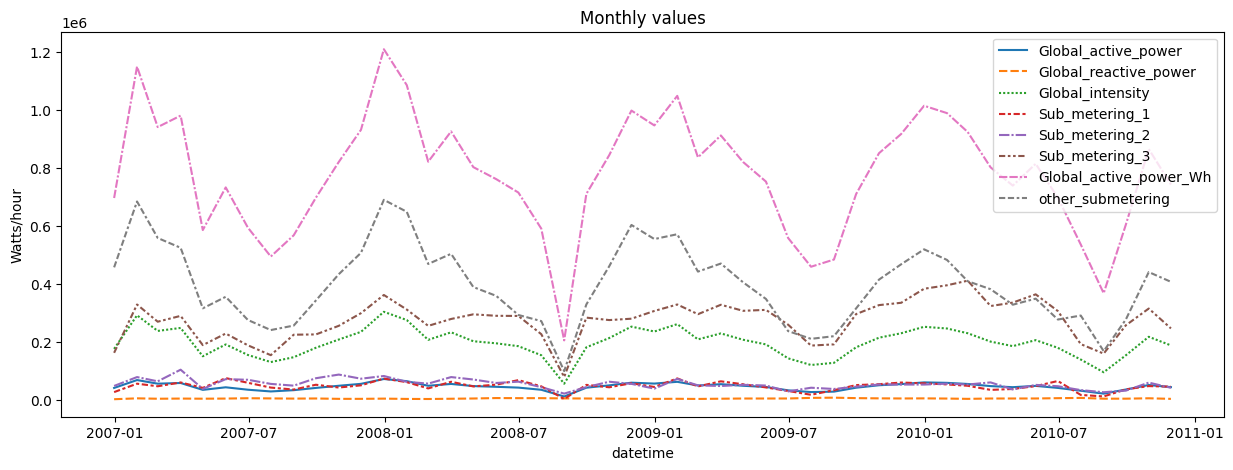

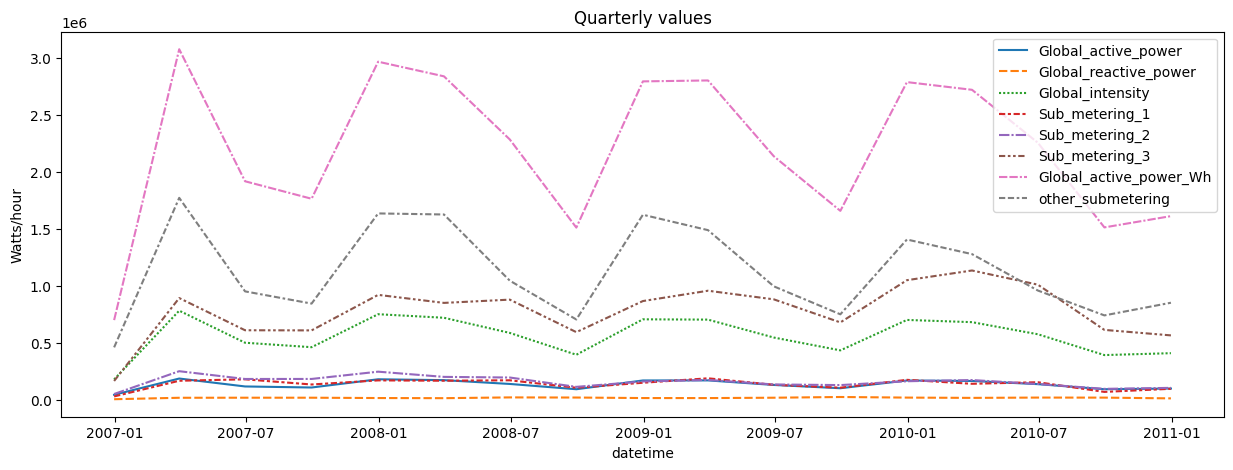

In [14]:
dataplots.plot_time_series(column=viz_cols, granularity="all")


> Distribution plots

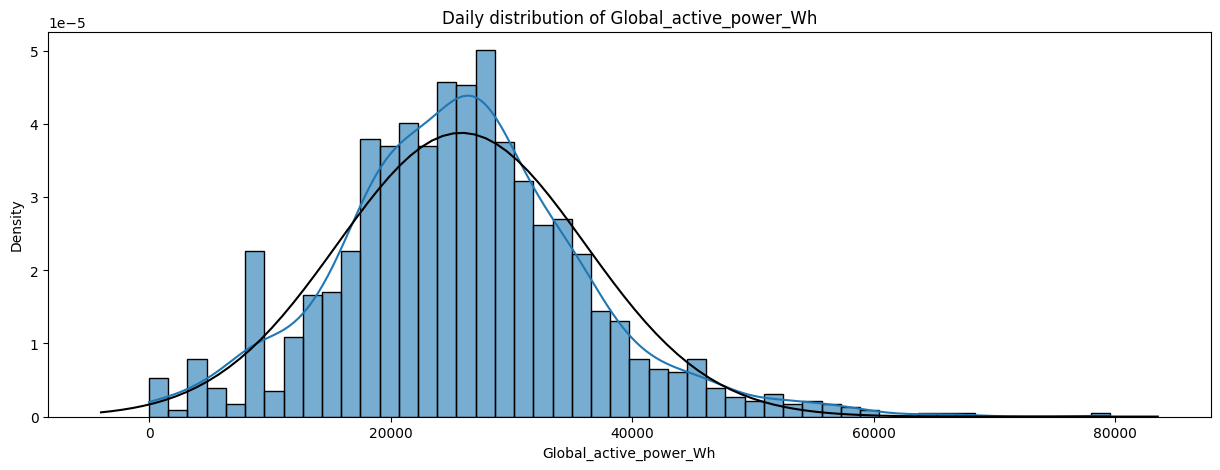

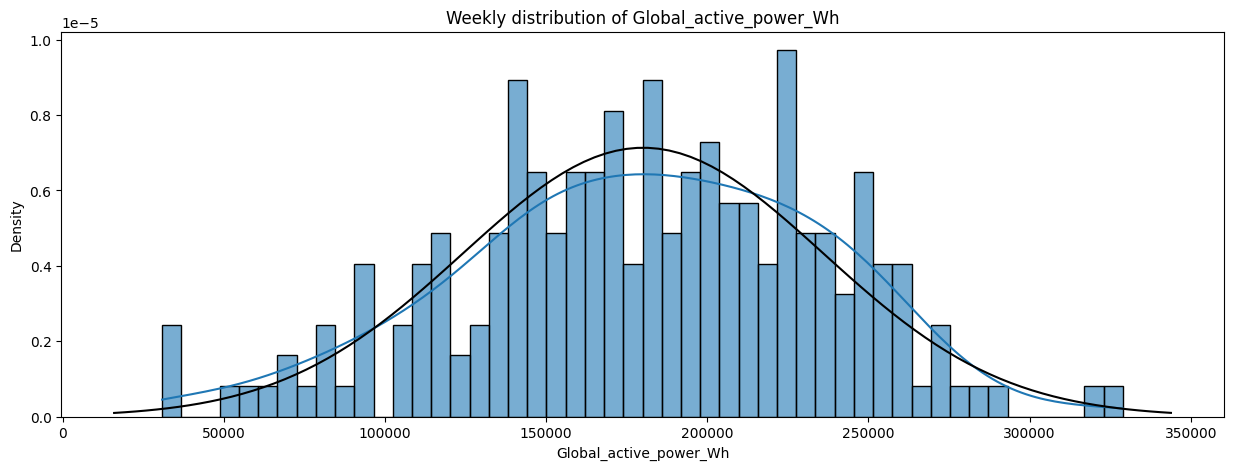

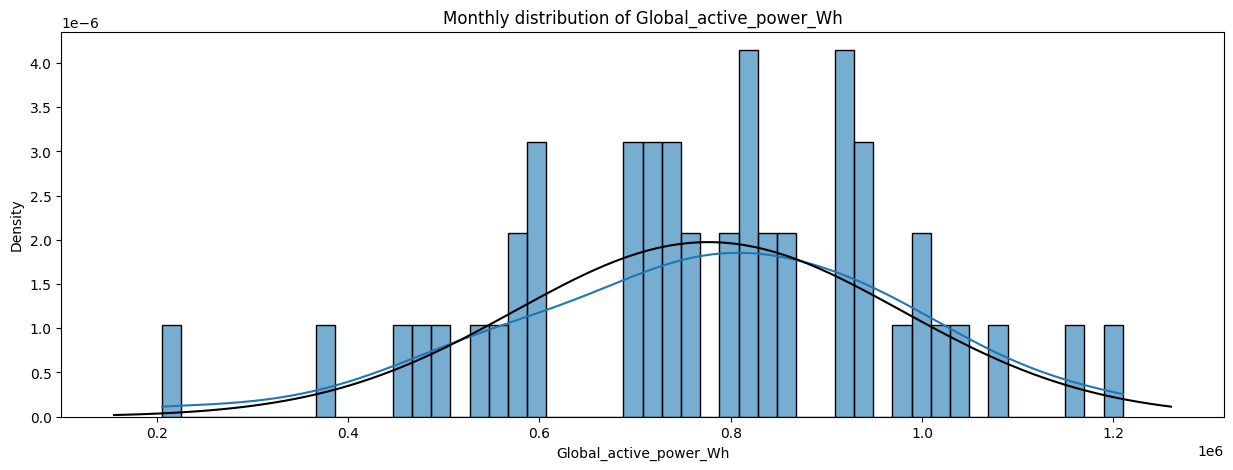

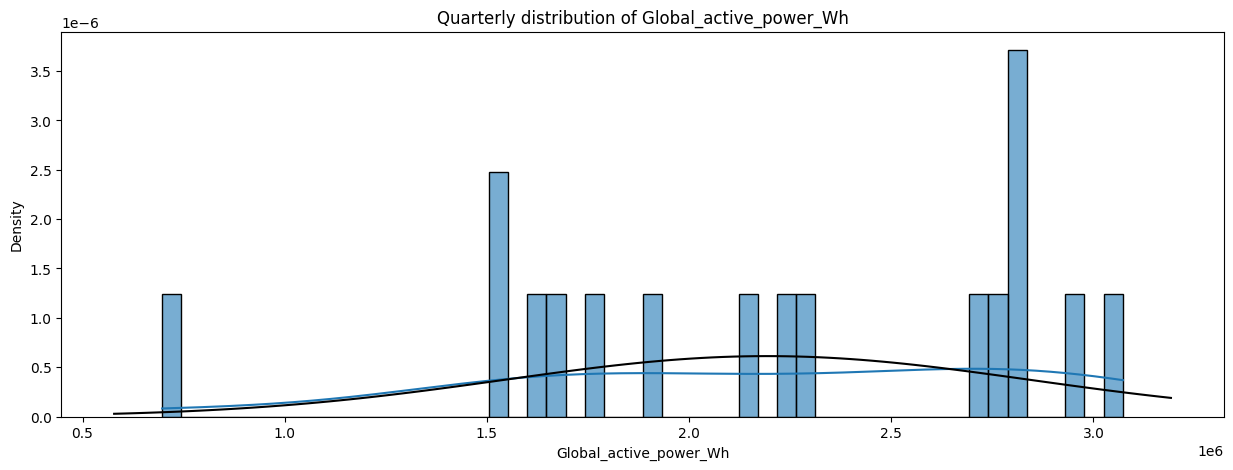

In [15]:
# Observation de la distribution de la puissance par rapport à une distribution Gaussienne
dataplots.plot_histogram(TARGET, granularity="all")


>  Pairplots

In [16]:
# sns.pairplot(df[['Global_active_power', 'Global_reactive_power',
#              'Voltage', 'Global_intensity', 'Sub_metering_2', 'Sub_metering_3']])


> Probability plots

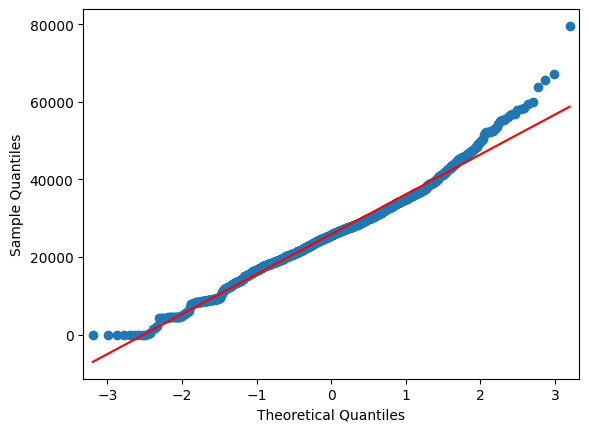

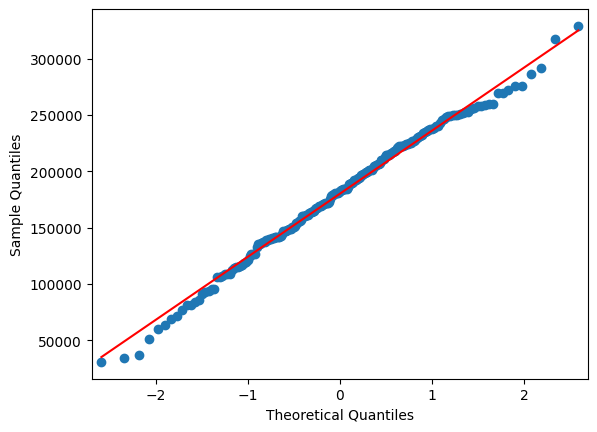

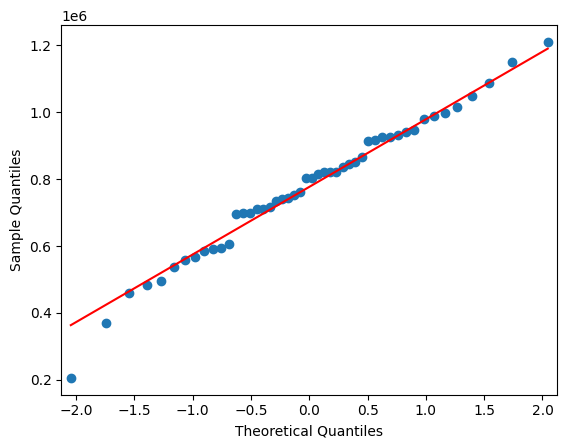

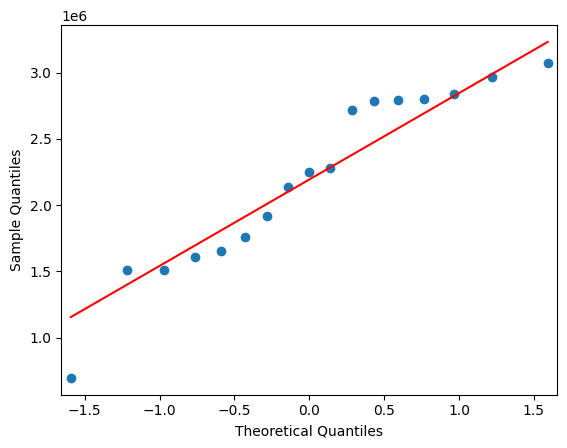

In [17]:
# Add probability plot for the column
dataplots.plot_prob(column=TARGET)


> Pattern analysis

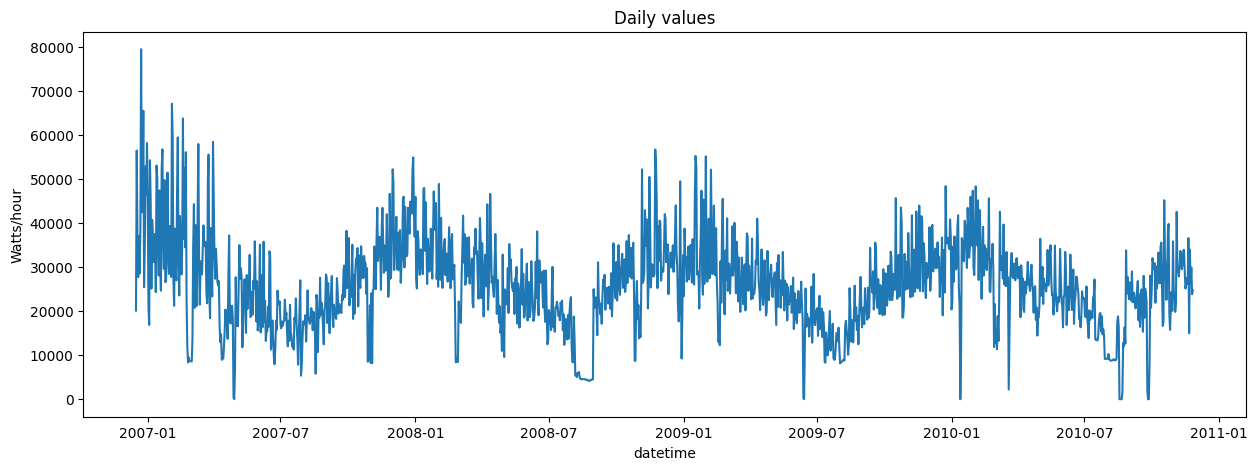

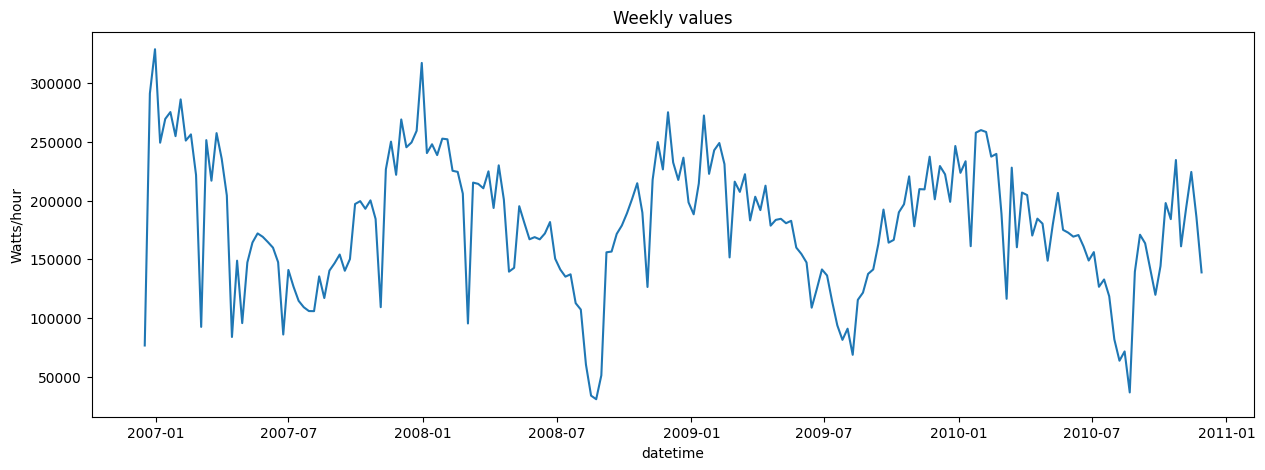

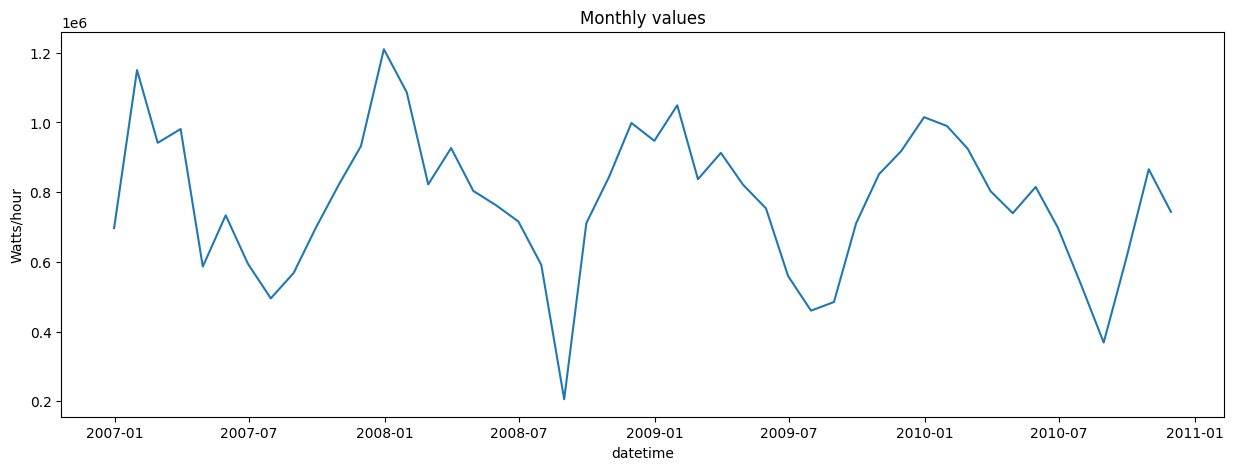

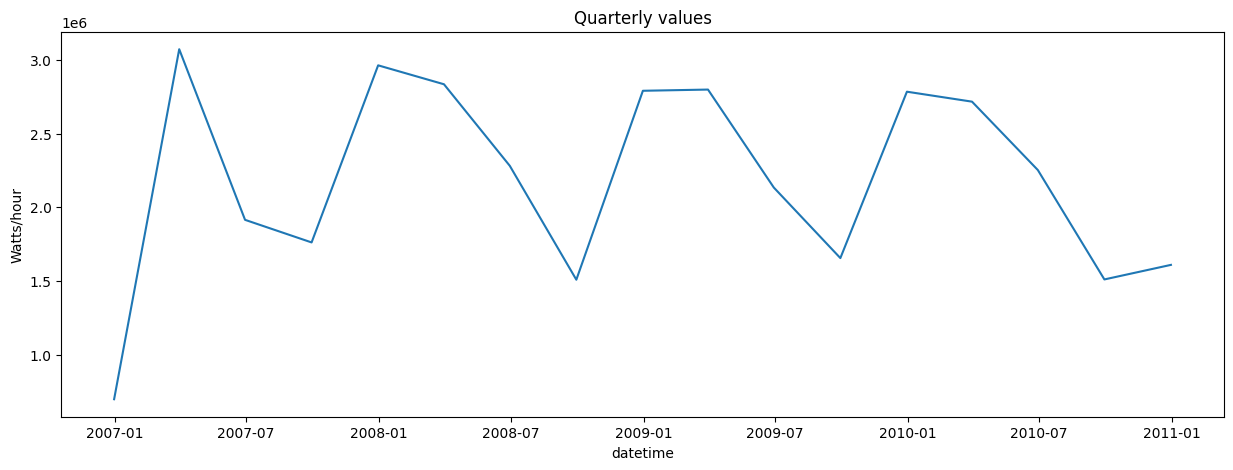

In [18]:
dataplots.plot_time_series(column=TARGET, granularity="all")


>  Breaking down the time variables to see patterns

In [19]:
analyzer = PatternAnalyzer(df)


In [20]:
sub_metering = ['Sub_metering_1', 'Sub_metering_2',
                'Sub_metering_3']


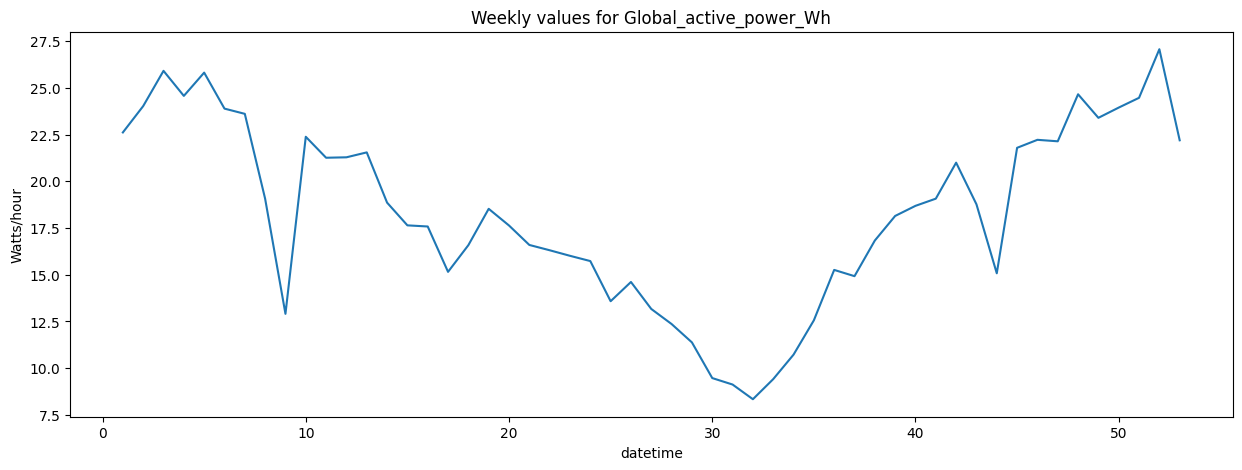

In [21]:
analyzer.plot_time_series(TARGET, "W")


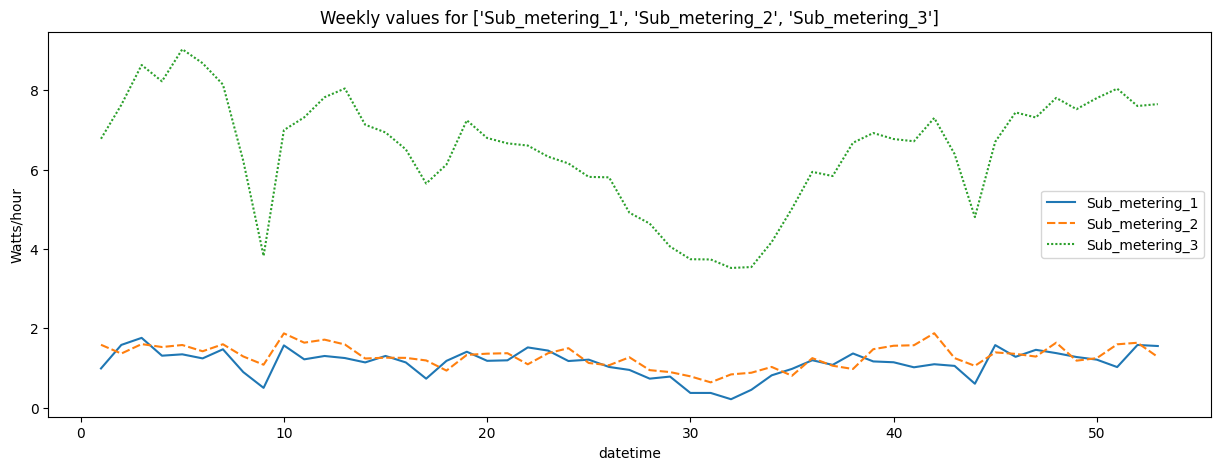

In [22]:
analyzer.plot_time_series(sub_metering, "W")


> Seasonal decomposition

Daily Decomposition of Global_active_power_Wh


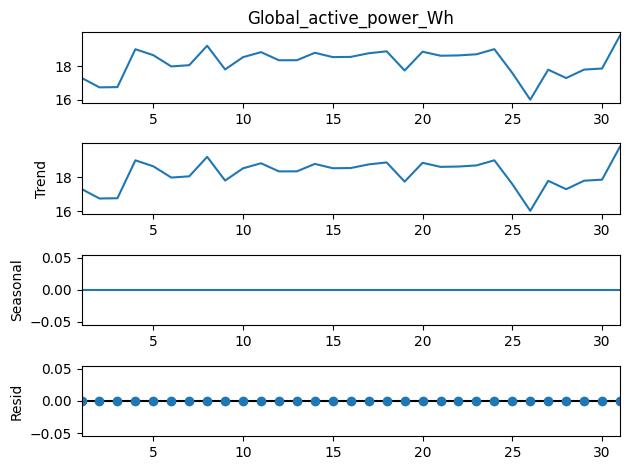

Weekly Decomposition of Global_active_power_Wh


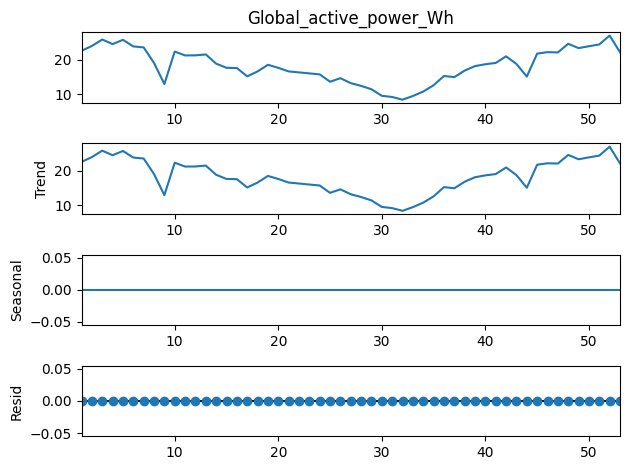

Monthly Decomposition of Global_active_power_Wh


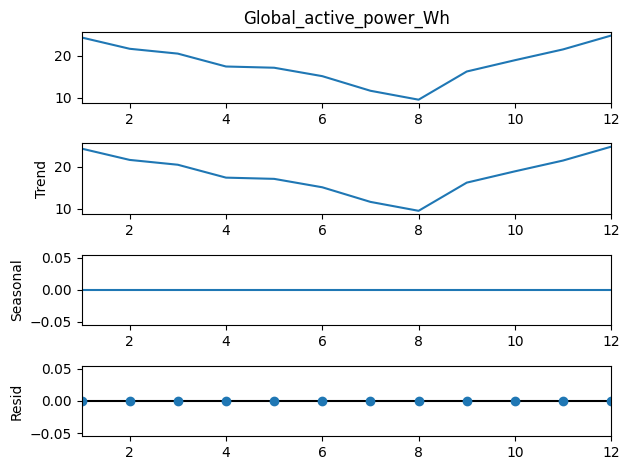

Quarterly Decomposition of Global_active_power_Wh


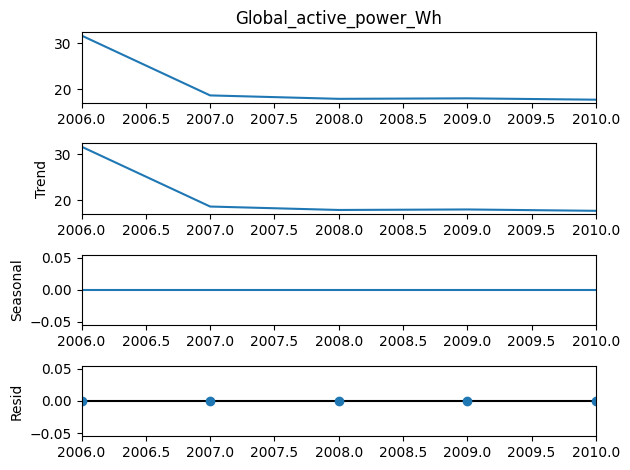

In [23]:
analyzer.seasonal_decompositation_additive(TARGET)


Daily Decomposition of Sub_metering_1


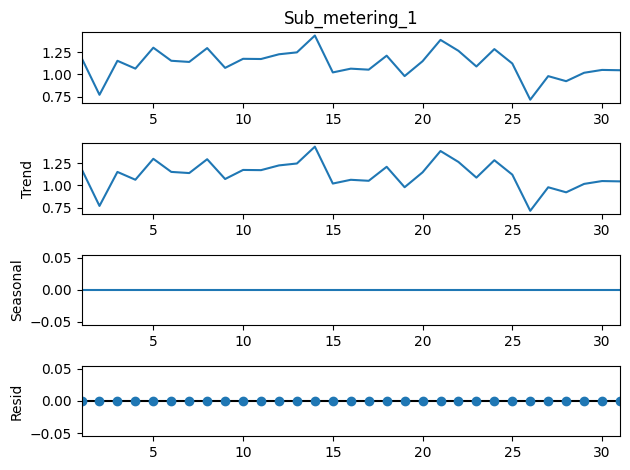

Weekly Decomposition of Sub_metering_1


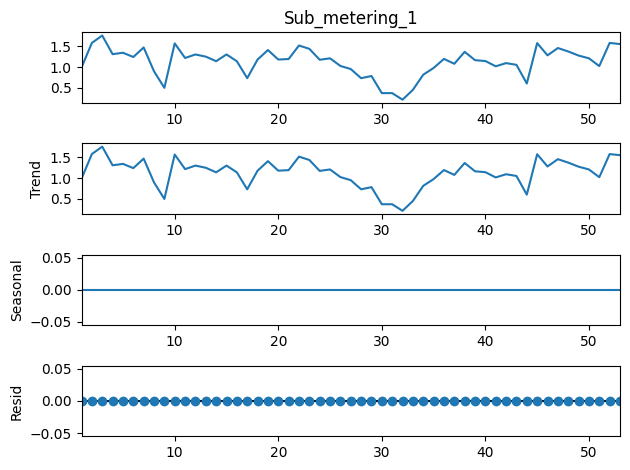

Monthly Decomposition of Sub_metering_1


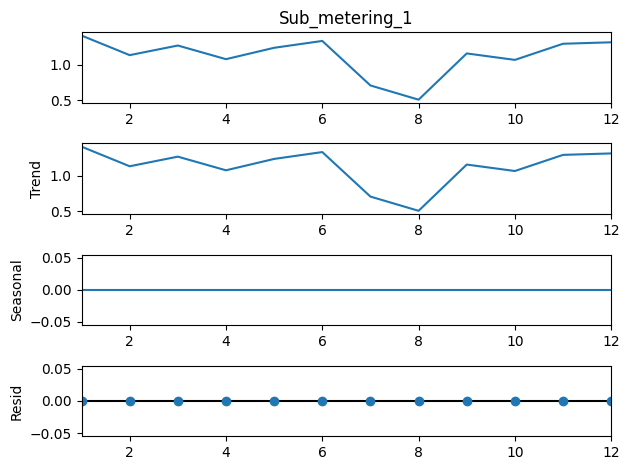

Quarterly Decomposition of Sub_metering_1


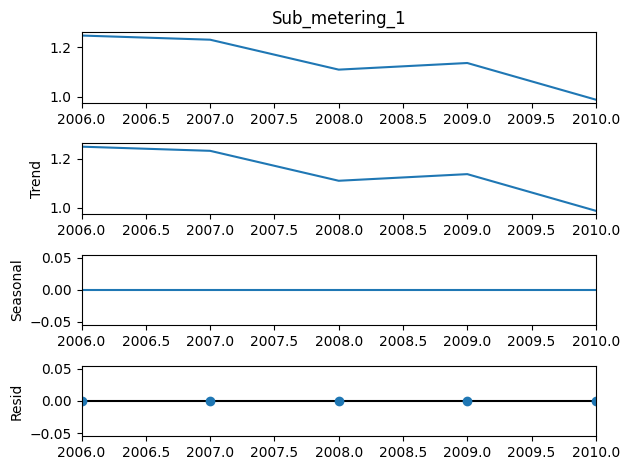

In [24]:
analyzer.seasonal_decompositation_additive("Sub_metering_1")


Daily Decomposition of Sub_metering_2


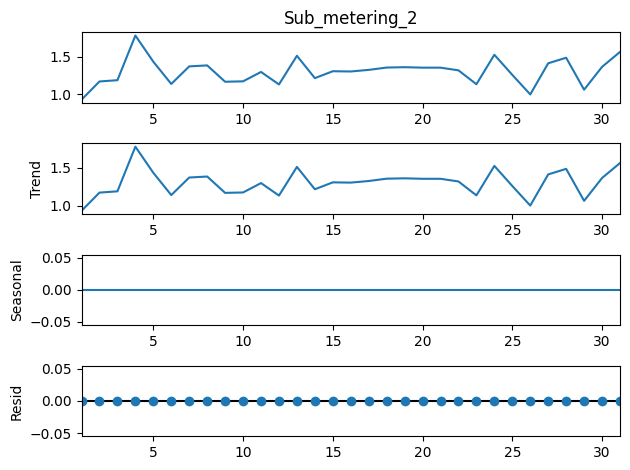

Weekly Decomposition of Sub_metering_2


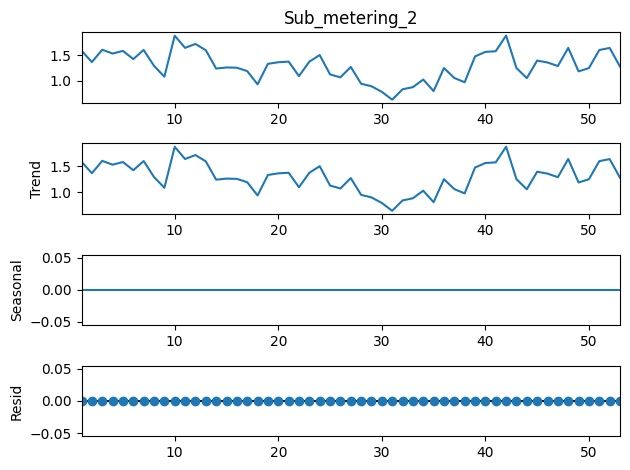

Monthly Decomposition of Sub_metering_2


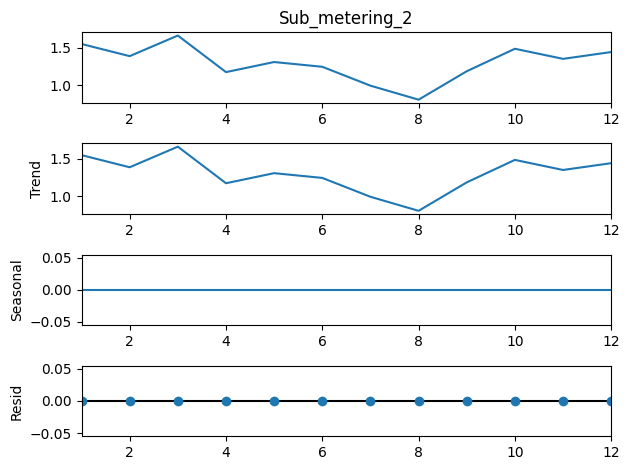

Quarterly Decomposition of Sub_metering_2


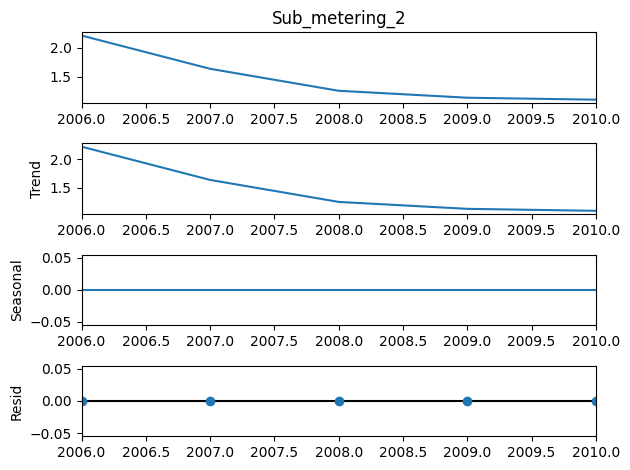

In [25]:
analyzer.seasonal_decompositation_additive("Sub_metering_2")


Daily Decomposition of Sub_metering_3


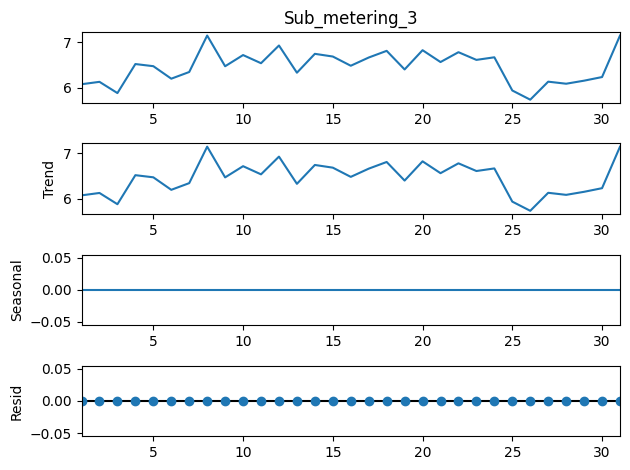

Weekly Decomposition of Sub_metering_3


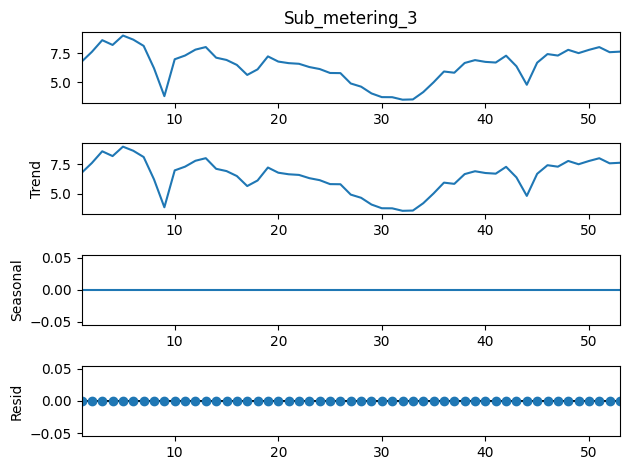

Monthly Decomposition of Sub_metering_3


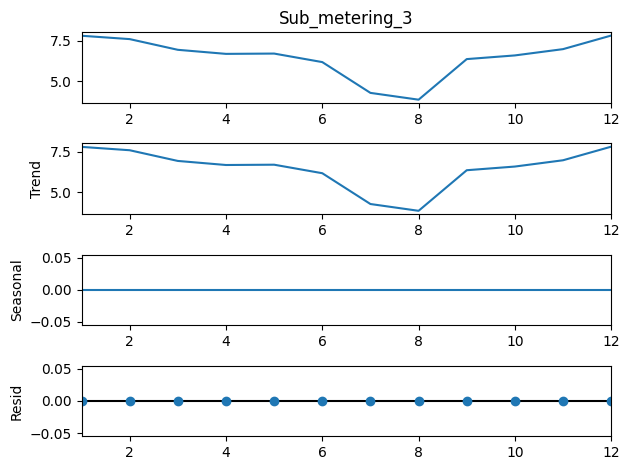

Quarterly Decomposition of Sub_metering_3


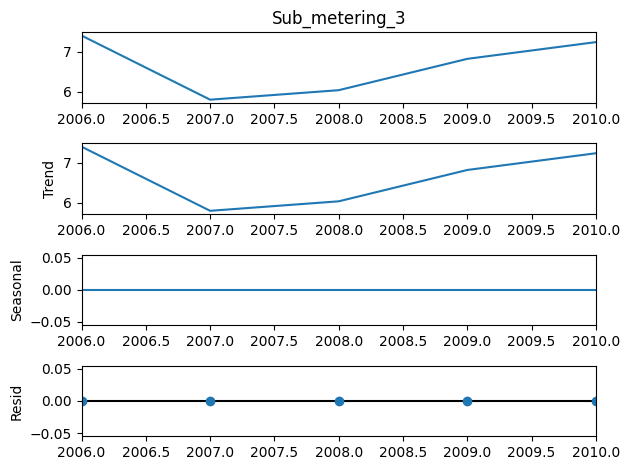

In [26]:
analyzer.seasonal_decompositation_additive("Sub_metering_3")


## 4. Data cleaning et imputation de données manquantes (si nécessaire)

In [27]:
# Nous avons des nan dans toutes les colonnes sauf la date
df.isna().any()


Date                      False
Time                      False
Global_active_power        True
Global_reactive_power      True
Voltage                    True
Global_intensity           True
Sub_metering_1             True
Sub_metering_2             True
Sub_metering_3             True
day                       False
month                     False
year                      False
Global_active_power_Wh     True
other_submetering          True
dtype: bool

In [28]:
# On vérifie si c'est bien toute la ligne qui est nan et c'est bien le cas.
mask = df['Global_active_power_Wh'].isna()
df.loc[~mask].isna().any()


Date                      False
Time                      False
Global_active_power       False
Global_reactive_power     False
Voltage                   False
Global_intensity          False
Sub_metering_1            False
Sub_metering_2            False
Sub_metering_3            False
day                       False
month                     False
year                      False
Global_active_power_Wh    False
other_submetering         False
dtype: bool

In [29]:
print("Comptage des NaN par colonne:")
print(df.isna().sum())

# Si bien cela peut paraître beaucoup, cela ne réprésente que 1,25% des observations.


Comptage des NaN par colonne:
Date                          0
Time                          0
Global_active_power       25979
Global_reactive_power     25979
Voltage                   25979
Global_intensity          25979
Sub_metering_1            25979
Sub_metering_2            25979
Sub_metering_3            25979
day                           0
month                         0
year                          0
Global_active_power_Wh    25979
other_submetering         25979
dtype: int64


In [30]:
print(
    f'Nombre de jours qui présentent des NaN: {df[df["Global_active_power_Wh"].isna()]["Date"].nunique()}')


Nombre de jours qui présentent des NaN: 82


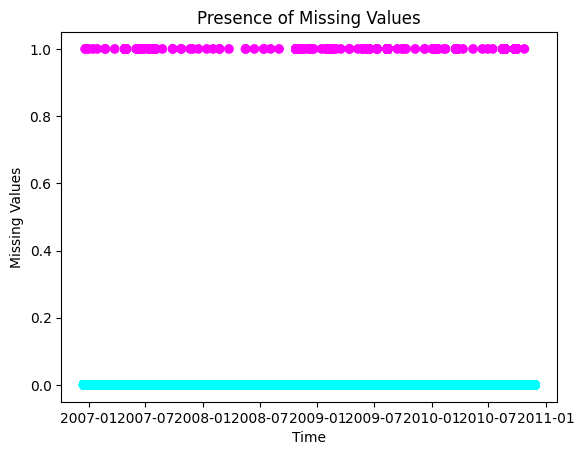

In [31]:
import matplotlib.pyplot as plt

df['missing'] = 0

mask = df['Global_active_power_Wh'].isna()
df.loc[mask, 'missing'] = 1

# Create a scatter plot with color-coded markers
plt.scatter(df.index, df['missing'], c=df['missing'], cmap='cool', marker='o')

# Set the axis labels and title
plt.xlabel('Time')
plt.ylabel('Missing Values')
plt.title('Presence of Missing Values')

# Show the plot
plt.show()


La distribution est normale, des NaN sont présent dans tous les dates. En conséquence, il est justifié de drop les valeurs manquantes

In [32]:
df.dropna(inplace=True)
df.drop(columns='missing', inplace=True)

## 5. Feature engineering en expliquant votre démarche et les variables créées

> transformation

Dire que certaines transformations ont été réalisée avant. Faire la justification.

>  Creating variables

In [33]:
fe = FeatureEngineer(df)
fe.winter_is_coming()
fe.day_and_night()

In [34]:
# # Create rolling window features
# window_sizes = [5, 30, 60]
# for window in window_sizes:
#     df[f'Global_active_power_mean_{window}'] = df['Global_active_power'].rolling(
#         window).mean()
#     df[f'Global_active_power_min_{window}'] = df['Global_active_power'].rolling(
#         window).min()
#     df[f'Global_active_power_max_{window}'] = df['Global_active_power'].rolling(
#         window).max()
#     df[f'Global_active_power_std_{window}'] = df['Global_active_power'].rolling(
#         window).std()


# # Apply Fourier Transform
# fft_vals = fft(df['Global_active_power'])
# abs_fft_vals = np.abs(fft_vals)
# num_samples = len(df)
# freqs = np.arange(num_samples) / num_samples
# top_freqs = freqs[np.argsort(-abs_fft_vals)[:5]]

# # Create Fourier Transform features
# for i, freq in enumerate(top_freqs, 1):
#     df[f'Global_active_power_freq_{i}'] = abs_fft_vals[int(freq*num_samples)]


In [35]:
df.columns


Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'day', 'month', 'year', 'Global_active_power_Wh',
       'other_submetering', 'winter', 'summer', 'hour', 'is_daytime'],
      dtype='object')

## 6. Préparation des données pour être fournies à un modèle de prévision ML/DL

> Faut-il stationnarisé la série ?

Une série chronologique est dite stationnaire si ses propriétés statistiques restent constantes dans le temps. Mathématiquement, cela peut être formulé comme suit :

Soit Yt une série chronologique et μ la moyenne de Yt. La série est stationnaire si :

$$ E(Y_t) = \mu,  t$$
$$ Var(Y_t) = \sigma^2, \forall t$$
$$ Cov(Y_t, Y_{t-k}) = Cov(Y_{t+m}, Y_{t+m-}) = \gamma(k), \forall t,m,k$$

Les séries chronologiques non stationnaires présentent des tendances, des saisonnalités et d'autres motifs qui peuvent affecter le comportement des données au fil du temps, rendant plus difficile la prévision précise des valeurs futures.

Cependant, des techniques peuvent être utilisées pour gérer les données non stationnaires. Les modèles ARIMA et STL peuvent être utilisés pour capturer les tendances et la saisonnalité dans les données non stationnaires. Mathématiquement, ARIMA peut être représenté comme suit :

$ARIMA(p,d,q)$ où p, d et q sont les ordres de l'autorégression, de la différenciation et de la moyenne mobile, respectivement.

Les modèles d'apprentissage automatique tels que les RNN et LSTM peuvent également être entraînés sur des données de séries chronologiques non stationnaires pour effectuer des prévisions précises. Mathématiquement, les RNN peuvent être représentés comme suit :

$$h_t = f(X_t, h_{t-1})$$

$$y_t = g(h_t)$$

Où $X_t$ représente les variables d'entrée à l'instant t, $h_t$ est l'état caché à l'instant $t$ et $y_t$ est la prédiction à l'instant $t$.

En conclusion, le choix des modèles de prévision de séries chronologiques dépend des propriétés statistiques de la série chronologique et des objectifs de prévision spécifiques.

> Doit-on agréger la série ? 

L'agrégation à une fréquence quotidienne peut être utile si nous cherchons à identifier les tendances et les modèles hebdomadaires ou saisonniers de notre série chronologique.

Par exemple, nous pourrions être intéressés par l'identification des pics de consommation qui se produisent chaque jour à des moments spécifiques, comme pendant les heures de pointe ou les heures creuses. Nous pourrions également chercher à identifier des tendances hebdomadaires, telles que des variations dans la consommation d'énergie en fonction des jours de la semaine.

En agrégeant nos données à une fréquence quotidienne, nous pouvons réduire le nombre d'observations, ce qui facilite l'analyse de la série chronologique. Cela peut également réduire la quantité de bruit dans nos données, ce qui peut rendre les modèles de prévision plus précis.

Cependant, il est important de noter que l'agrégation peut entraîner une perte d'informations importantes, en particulier quand les variations intra-journalières sont importantes dans notre série chronologique.

In [36]:
from AnalyzerTS import StationnaryViz
from AnalyzerTS import StationarityTest

In [37]:
#Agregation de la série à une fréquence quotidienne
daily_df = df.resample('D').sum()


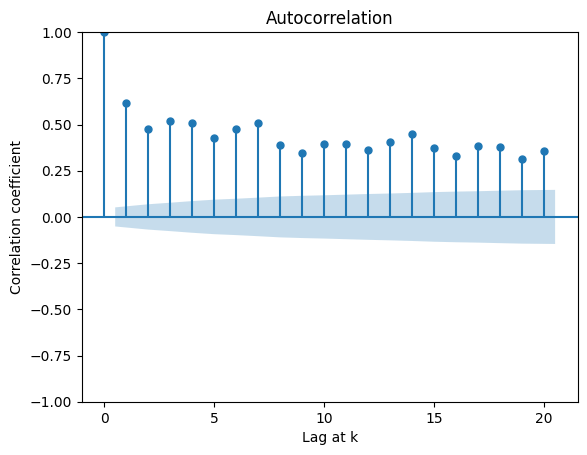

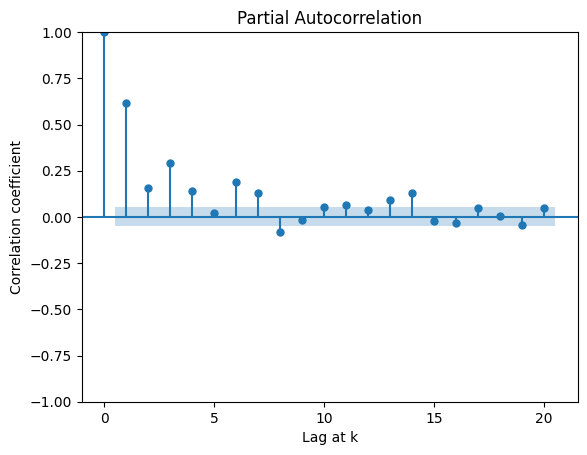

In [38]:
sv = StationnaryViz(daily_df, TARGET)
sv.plot_target()
sv.plot_autocorrelation_target()
sv.plot_partial_autocorrelation_target()

In [39]:
st = StationarityTest(daily_df)
st.adf_test([TARGET])
st.kpss_test([TARGET])
st.pp_test([TARGET])

ADF test pour Global_active_power_Wh:
ADF statistique: -3.849781061188022
p-value: 0.0024371416121418007
Valeurs critiques: {'1%': -3.434966750462565, '5%': -2.8635789736973725, '10%': -2.5678555388041384}
L'hypothèse nulle de non stationnarité a été rejeté, la série est donc stationnaire. 

KPSS test pour Global_active_power_Wh:
KPSS statistique: 0.24986905002729629
p-value: 0.1
Lag utilisé: 23
L'hypothèse nulle de non stationnarité ne peux pas etre rejeté, la série est donc non stationnaire.

Phillips-Perron test pour Global_active_power_Wh:
ADF statistique: -3.811902134899496
p-value: 0.015967787750138355
Lag utilisé: 22
L'hypothèse nulle de non stationnarité a été rejeté, la série est donc stationnaire. 



/Users/sarrabenyahia/Documents/GitHub/deep-q-learning-time-series/.env/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




La présence de saisonnalité peut expliquer le résultat du test KPSS, qui a montré que l'hypothèse nulle de non-stationnarité ne pouvait pas être rejetée. Le test KPSS est souvent sensible aux effets de saisonnalité dans les séries chronologiques, car il teste l'hypothèse que la moyenne de la série est constante sur toute la période d'observation, ce qui peut ne pas être le cas si la série présente une saisonnalité.

Dans notre cas, les tests ADF et Phillips-Perron ont indiqué que la série est stationnaire, tandis que le test KPSS a indiqué que la série est non stationnaire. Les tests ADF et Phillips-Perron sont des tests paramétriques qui testent l'hypothèse de présence de racine unitaire dans la série chronologique, tandis que le test KPSS est un test non paramétrique qui test l'hypothèse de l'absence de racine unitaire dans la série.

Une explication possible pour les résultats contradictoires est que la série chronologique est proche d'être stationnaire, mais pas complètement. Dans de tels cas, les tests paramétriques peuvent indiquer que la série est stationnaire, tandis que le test non paramétrique peut indiquer une non-stationnarité marginale.

> Essai de stationnarisation de la target

In [49]:
df_stationnarised = daily_df.copy()
df_stationnarised[TARGET] = df_stationnarised[TARGET].diff()
df_stationnarised = df_stationnarised.dropna()

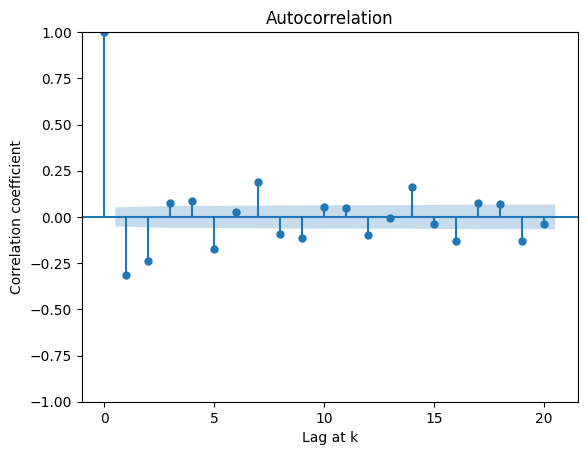

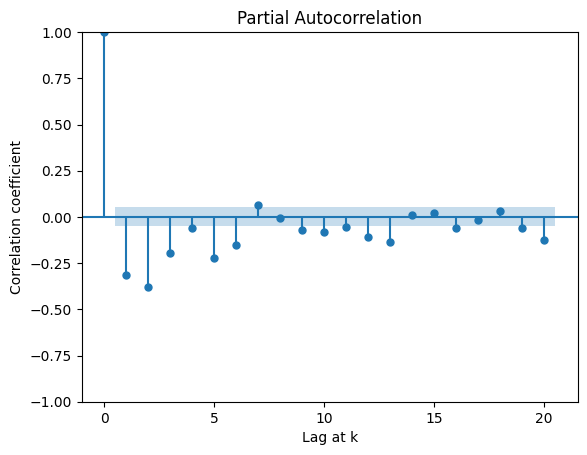

In [50]:
sv = StationnaryViz(df_stationnarised, TARGET)
sv.plot_target()
sv.plot_autocorrelation_target()
sv.plot_partial_autocorrelation_target()

In [51]:
st = StationarityTest(df_stationnarised)
st.adf_test([TARGET])
st.kpss_test([TARGET])
st.pp_test([TARGET])

ADF test pour Global_active_power_Wh:
ADF statistique: -10.911301876311757
p-value: 1.095216561931174e-19
Valeurs critiques: {'1%': -3.434966750462565, '5%': -2.8635789736973725, '10%': -2.5678555388041384}
L'hypothèse nulle de non stationnarité a été rejeté, la série est donc stationnaire. 

KPSS test pour Global_active_power_Wh:
KPSS statistique: 0.0326882069601293
p-value: 0.1
Lag utilisé: 84
L'hypothèse nulle de non stationnarité ne peux pas etre rejeté, la série est donc non stationnaire.

Phillips-Perron test pour Global_active_power_Wh:
ADF statistique: -10.92013371404366
p-value: 3.16251778358764e-17
Lag utilisé: 21
L'hypothèse nulle de non stationnarité a été rejeté, la série est donc stationnaire. 



/Users/sarrabenyahia/Documents/GitHub/deep-q-learning-time-series/.env/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Nous avons utilisé plusieurs méthodes de transformations de la série pour la stationnarisé selon le test de KPSS (différenciation, logarithme, décomposition, Box-Cox etc...). Cependant aucune de ces transformations n'arrivent à stationnarisé complètement la série. Il se peut que nous soyons face à un cas de série intrinsèquement non-stationnaire.
Nous pouvons remarquer que visuellement, on peut remarquer des variation cyclique de la données.

La consommation d'électricité des ménages sur plusieurs années peut être considérée comme une série chronologique intrinsèquement non-stationnaire. La raison en est que la consommation d'électricité est souvent influencée par des facteurs saisonniers, tels que la température, les jours fériés, les week-ends, etc. En outre, la consommation d'électricité peut également être influencée par des facteurs économiques, démographiques ou technologiques, qui peuvent changer au fil du temps.

Cela signifie que la consommation d'électricité des ménages sur plusieurs années peut présenter une tendance, une saisonnalité ou une variation cyclique qui ne peut pas être facilement éliminée par des transformations ou des modèles de prévision standard. Dans de tels cas, il peut être utile d'utiliser des modèles de prévision qui prennent en compte la non-stationnarité de la série

Il existe plusieurs approches pour modéliser une série chronologique non stationnaire, telles que :

- Modèles de différences : Les modèles de différences comprennent des termes de différenciation pour modéliser la tendance de la série chronologique. Les modèles ARIMA sont un exemple de modèle de différences, qui comprend des termes pour modéliser la tendance, la saisonnalité et les résidus.

- Modèles de régression : Les modèles de régression incluent des termes pour modéliser les relations entre la série chronologique et d'autres variables explicatives. Les variables explicatives peuvent inclure des variables économiques, des données météorologiques ou des données sociodémographiques. Dans notre cas nous avons ajouté 2 variables de temps dans notre feature engineering (is_winter et is_day)

- Modèles de réseaux de neurones : Les modèles de réseaux de neurones peuvent être utilisés pour modéliser les séries chronologiques non linéaires et complexes. Les réseaux de neurones peuvent apprendre à partir des motifs temporels dans les données et à modéliser les relations entre les variables.

> Train-Test-OOT Split

In [ ]:

# # calculate the index values for the three parts
# num_rows = len(df)
# idx_1 = int(num_rows * 0.7)
# idx_2 = idx_1 + int(num_rows * 0.2)

# # split the data into three parts based on the index
# train = df.iloc[:idx_1]
# test = df.iloc[idx_1:idx_2]
# oot = df.iloc[idx_2:]

# X_train = train.drop(columns=target)
# y_train = train[target]

# X_test = test.drop(columns=target)
# y_test = test[target]

# X_oot = oot.drop(columns=target)
# y_oot = oot[target]

# # print out the number of rows in each part
# print(f"Number of rows in part 1: {len(part_1)}")
# print(f"Number of rows in part 2: {len(part_2)}")
# print(f"Number of rows in part 3: {len(part_3)}")


> Choix des variables explicatives

> Dataframe final

## 7. Sélection de différents modèles (explications des critères de sélection, choix de la métrique...)

> Modèle de différence

Le modèle ARIMA (AutoRegressive Integrated Moving Average) est un modèle de prévision de séries chronologiques qui combine des termes d'autorégression (AR), de moyenne mobile (MA) et de différenciation intégrée (I). Les termes AR et MA modélisent les relations entre les observations de notre série chronologique, tandis que le terme I modélise la tendance de notre série chronologique. 

Le modèle ARIMA peut être écrit mathématiquement comme suit :

* AR(p) : Un modèle AR d'ordre p est défini par l'équation suivante :

$$ y_t = c + \phi_1 * y_{t-1} + \phi_2 * y_{t-2} + ... + \phi_p * y_{t-p} + \epsilon_t$$

où $y_t$ est la valeur de notre série chronologique à l'instant $t$, $c$ est la constante du modèle, $\phi_1$, $\phi_2$, ..., $\phi_p$ sont les coefficients d'autorégression, et $epsilon_t$ est le terme d'erreur.

* MA(q) : Un modèle MA d'ordre q est défini par l'équation suivante 
$$y_t = c + \epsilon_t + \theta_1 * \epsilon_{t-1} + \theta_2 * \epsilon_{t-2} + ... + \theta_q * \epsilon_{t-q}$$

où $\theta_1, \theta_2, ..., \theta_q$ sont les coefficients de la moyenne mobile.

* Différenciation intégrée (I) : La différenciation intégrée est utilisée pour modéliser la tendance de notre série chronologique. 
La différenciation intégrée d'ordre d est définie par l'équation suivante :
$$diff(y_t, d) = (1 - L)^d * y_t$$

où $L$ est l'opérateur de retard, $diff(y_t, d)$ est la différence d'ordre $d$ de $y_t$, et $d$ est l'ordre de différenciation.

Le modèle ARIMA est défini par les trois paramètres p, d et q, qui représentent respectivement l'ordre d'autorégression, l'ordre de différenciation intégrée et l'ordre de la moyenne mobile. Le modèle ARIMA peut être écrit de manière plus générale comme suit :

$$ARIMA(p,d,q): y_t = c + \phi_1 * diff(y_t,1) + ... + \phi_p * diff(y_t,p) + \epsilon_t + \theta_1 * \epsilon_{t-1} + ... + \theta_q * \epsilon_{t-q}$$



In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Initialiser les variables pour enregistrer les valeurs optimales
best_aic = np.inf
best_order = None

# Itérer sur différentes valeurs de p, d, et q
for p in range(5):
    for d in range(3):
        for q in range(5):
            try:
                # Créer un modèle ARIMA avec les ordres actuels
                model = ARIMA(train_data, order=(p, d, q))
                
                # Ajuster le modèle aux données d'apprentissage
                model_fit = model.fit()
                
                # Calculer l'AIC pour le modèle actuel
                aic = model_fit.aic
                
                # Mettre à jour les valeurs optimales si l'AIC est plus petit
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
            except:
                continue

# Créer le modèle final avec les ordres optimaux
final_model = ARIMA(data, order=best_order)

# Ajuster le modèle aux données
final_model_fit = final_model.fit()

# Faire des prévisions pour les prochaines 10 périodes
forecast = final_model_fit.forecast(steps=10)

# Afficher les prévisions
print(forecast)


> Modèle de régression

> Modèle de réseau de neurones

## 8. Evaluation de la performance des modèles (recherche d'hyperparamètres, contrôle de l’overfitting, comparaison des performances) sur différents horizons de prédiction

## 9. Discussion autour de la performance des modèles


## 10. Synthèse et conclusions, pistes d’améliorations envisagées